<a href="https://www.coursera.org/learn/applying-data-analytics-business-in-finance"> <img src="./resources/illinois_banner.png" alt="applying-data-analytics-business-in-finance"/> </a>

# Performance Measures and Holt-Winters Model 

*This lab was developed by: <br> Jose Luis Rodriguez, Director of Margolis Market Information Lab, R.C. Evans Innovation Fellow at Gies College of Business
<br> Nam Hoang Nguyen, Master of Science in Finance, iMBA Teaching Assistant at Gies College of Business*


On this lab we will introduce analytical methods to analyze time series data to build forecasting models. We will analyze financial data that is usually in raw format and transform it to a time series dataset. Topics include forecasting performance measures, moving average, exponential smoothing methods, and the Holt-Winters method.

* Understand commonly used performance measures. Learn how to calculate and interpret the performance measures.
* Develop a basic understanding of moving averages and exponential smoothing. Identify three types of exponential smoothing methods and their implementation.
* Develop an understanding about autoregression, knowing its role in analyzing time series data and performing the analysis.

### Packages and Configurations

* tidyverse: https://www.tidyverse.org/
* lubridate: https://lubridate.tidyverse.org/
* forecast: https://cran.r-project.org/web/packages/forecast/
* xts: https://cran.r-project.org/web/packages/xts

In [1]:
# Suppres Package Warning
quietly <- suppressPackageStartupMessages

# Disable scientific notation
options(scipen = 9999)

# Change chart dimension
options(repr.plot.width=12, repr.plot.height=7)

# Load package suppress warning
quietly(library(xts))
quietly(library(tidyverse))
quietly(library(lubridate))
quietly(library(forecast))

## 1. Data Import and Exploration

In [2]:
# Read the kraken_clean.csv file a kraken_df
kraken_df = read_csv("data/kraken_clean.csv")

Parsed with column specification:
cols(
  datetime = col_datetime(format = ""),
  crypto = col_character(),
  pct_change = col_double(),
  price = col_double(),
  volume = col_double(),
  trend = col_double(),
  all_time_high = col_double(),
  new_crypto = col_double(),
  date = col_date(format = ""),
  time = col_time(format = "")
)



In [3]:
# Inspect the first few rows of the DataFrame
head(kraken_df)

datetime,crypto,pct_change,price,volume,trend,all_time_high,new_crypto,date,time
<dttm>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<date>,<time>
2020-08-05 03:48:49,XBT,0.0040,11194.0000,111100000,-1,0,0,2020-08-05,03:48:49
2020-08-05 03:48:49,ETH,0.0080,389.8100,68800000,1,0,0,2020-08-05,03:48:49
2020-08-05 03:48:49,XRP,0.0320,0.3010,20300000,-1,0,0,2020-08-05,03:48:49
2020-08-05 03:48:49,USDT,0.0001,1.0005,18600000,-1,0,0,2020-08-05,03:48:49
2020-08-05 03:48:49,LINK,0.0650,9.8602,14800000,1,0,0,2020-08-05,03:48:49
2020-08-05 03:48:49,XTZ,0.0540,3.2424,10300000,1,0,0,2020-08-05,03:48:49


In [4]:
# Subset a DataFrame of XBT crypto
xbt_df = kraken_df[kraken_df$crypto == "XBT",]

In [5]:
# Convert xbt_df to a time series by: 
# First delete unnecessary column (crypto, datetime, date and time)
# Second convert index to POSIXct time format and order by time

xbt_xts = xts(select(xbt_df,-c("crypto","datetime","date","time")), 
             order.by = as.POSIXct(strptime(xbt_df$date,"%Y-%m-%d")))

In [6]:
# Get XBT daily price
daily_price = xbt_xts[,'price']

# Get XBT weekly price by taking mean price of each week
weekly_price = apply.weekly(daily_price, mean)

# Get XBT monthly price by taking mean price of each month
monthly_price = apply.monthly(daily_price, mean)

# Get XBT quarterly price by taking mean price of each quarter
quarterly_price = apply.quarterly(daily_price, mean)

## 2. Forecasting method

To start forecasting we need to make a couple of changes to the target variable (price) from the xbt_ts timeseries dataset.

The R forecast packages requires a `ts` timeseries class object to make predictions. To forecast Bitcoin prices we first create a **variable with prices**, **extract the start year** and the **numeric day of the year** to create `xbt_start` the time of the first observation.

### 2.1. Average Method - `meanf()` Function

`meanf()` Returns forecasts and prediction intervals for an iid model applied to y.

**Function Arguments**

* **y**: a numeric vector or time series of class ts
* **h**: Number of periods for forecasting
* **level**: Confidence levels for prediction intervals.
* **fan**: If TRUE, level is set to seq(51,99,by=3). This is suitable for fan plots.
* **lambda**: Box-Cox transformation parameter. If lambda="auto", then a transformation is automatically selected using BoxCox.lambda. The transformation is ignored if NULL. Otherwise, data transformed before model is estimated.
* **biasadj**: Use adjusted back-transformed mean for Box-Cox transformations. If transformed data is used to produce forecasts and fitted values, a regular back transformation will result in median forecasts. If biasadj is TRUE, an adjustment will be made to produce mean forecasts and fitted values.
* **bootstrap**: If TRUE, use a bootstrap method to compute prediction intervals. Otherwise, assume a normal distribution.
* **npaths**: Number of bootstrapped sample paths to use if bootstrap==TRUE.

#### XBT Quarterly Prices Forecast - `meanf` Function

In [7]:
# Get the first observation in quarterly_price
xbt_start = quarterly_price[1]

# Select the year and quarter of the first observation
xbt_start = c(year(xbt_start), quarter(xbt_start))

In [8]:
# Create a quarterly time series dataset
# start date = xbt_start and frequency = 4

quarterly_ts = ts(quarterly_price,
                  start = xbt_start,
                  frequency = 4)


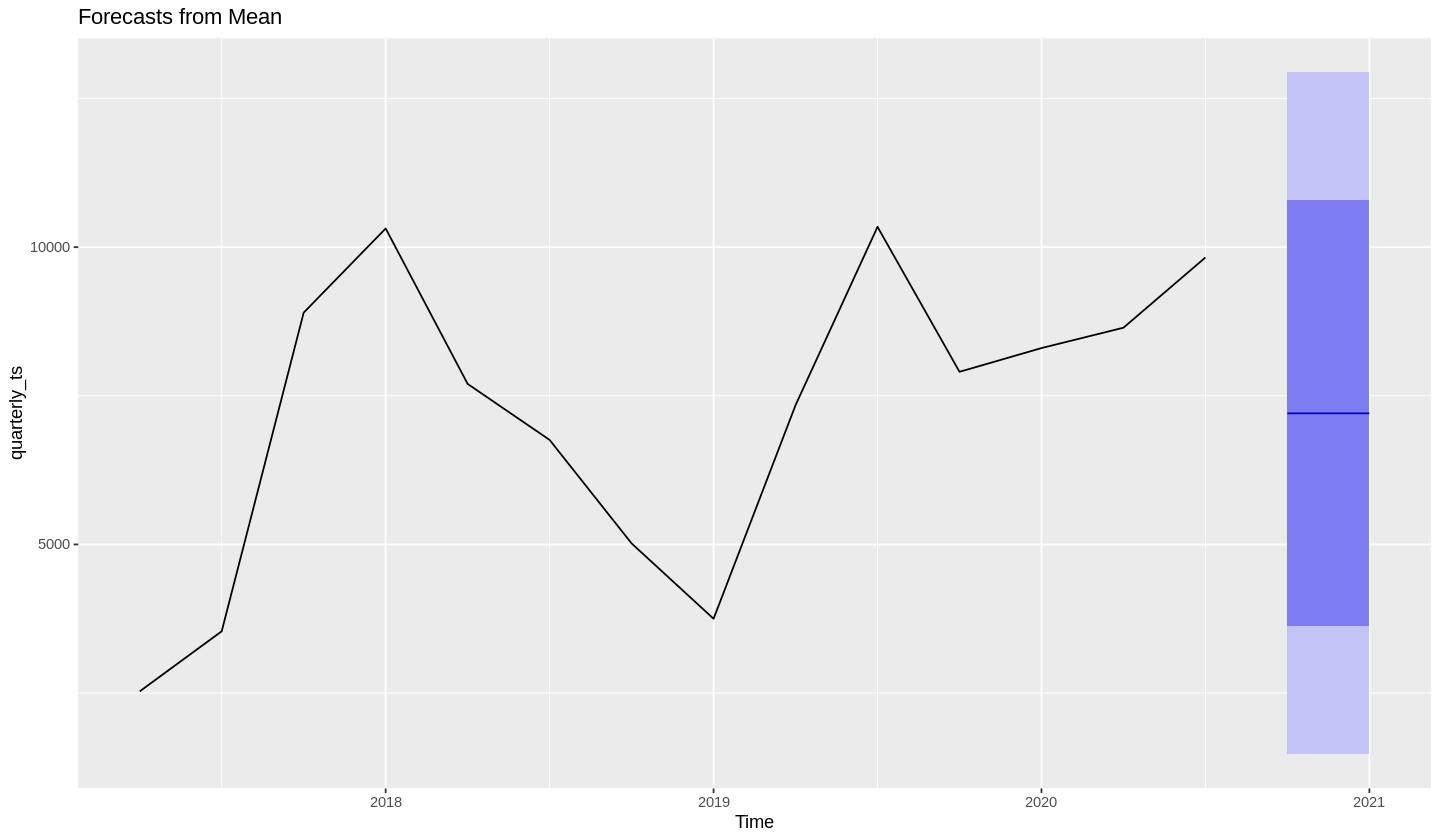

In [9]:
# Average method 
# Forecast 2 periods into the future (h = 2) using meanf() function

xbt.fcast = meanf(y = quarterly_ts, h = 2)

# Plot the quarterly timeseries + forecast
autoplot(xbt.fcast)


Average method makes forecast by taking the average value of the series.

#### XBT Monthly Prices Forecast - `meanf` Function

In [10]:
# Get the first observation in monthly_price
xbt_start = monthly_price[1]

# Get year and month of the first observation
xbt_start = c(year(xbt_start),month(xbt_start))

# Get the last observation in monthly_price
xbt_end = monthly_price[length(monthly_price)]

# Get year and month of the last observation
xbt_end = c(year(xbt_end), month(xbt_end))

In [11]:
# Create a monthly time series
# start date = xbt_start, end date = xbt_end and frequency = 4

monthly_ts =  ts(monthly_price,
                 start = xbt_start,
                 end = xbt_end,
                 frequency = 12)

In [12]:
# Average method: Forecast 3 periods into the future (h = 3)
xbt.fcast = meanf(y = monthly_ts, h = 3)

In [13]:
# Print out forecasted results
xbt.fcast

         Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
Sep 2020       7452.757 3698.421 11207.09 1625.368 13280.14
Oct 2020       7452.757 3698.421 11207.09 1625.368 13280.14
Nov 2020       7452.757 3698.421 11207.09 1625.368 13280.14

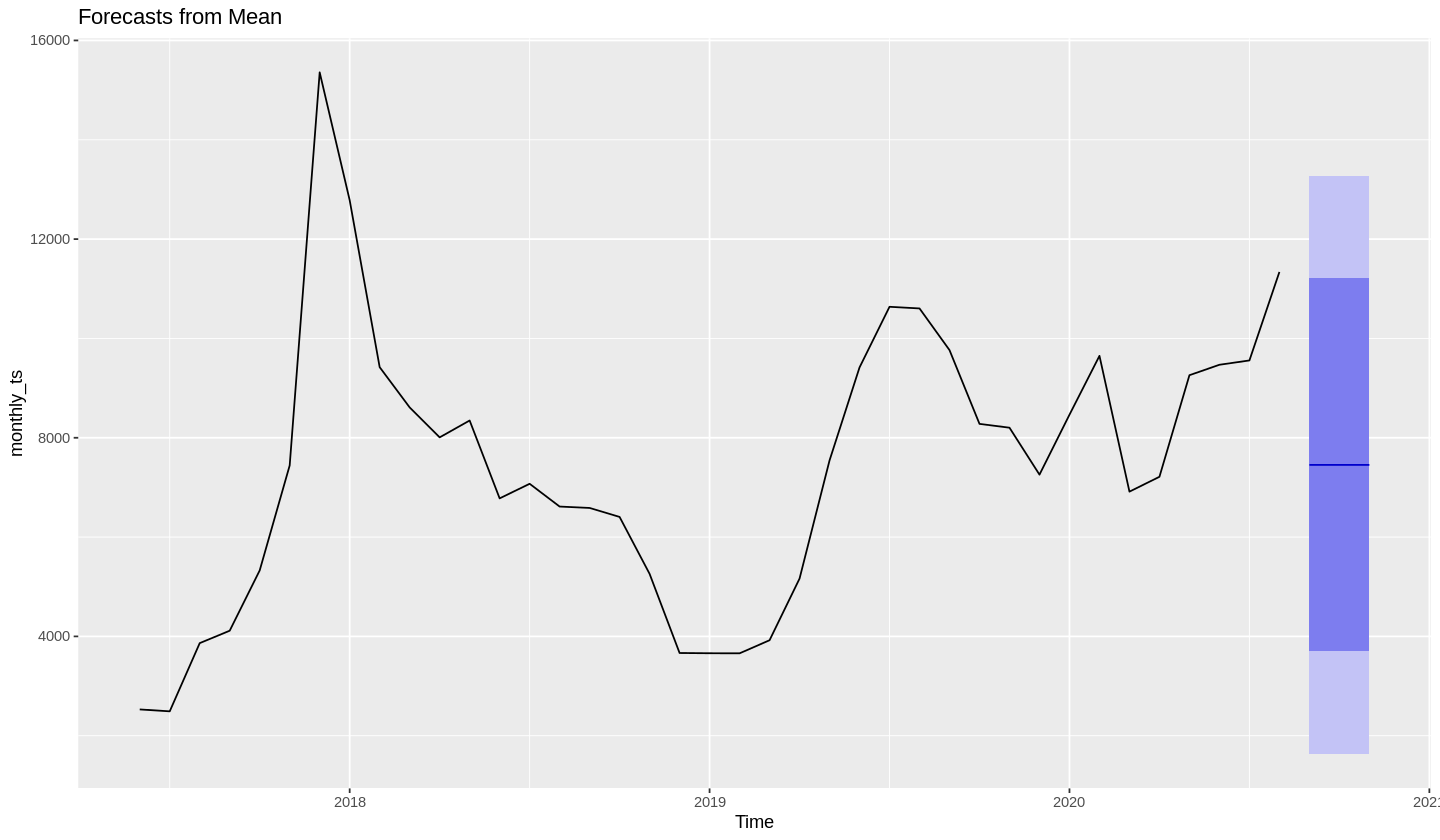

In [14]:
# Plot the monthly timeseries + forecast
autoplot(xbt.fcast)

The monthly timeseries are less smooth than the quarterly timeseries as expected.

### 2.2. Naive Method and Random Walk - `naive` Function

**Description**
`naive()` is simply a wrapper to rwf() for simplicity. `rwf()` returns forecasts and prediction intervals for a *random walk* with drift model applied to y. This is equivalent to an `ARIMA(0,1,0)` model with an optional drift coefficient.

`snaive()` returns forecasts and prediction intervals from an `ARIMA(0,0,0)(0,1,0)m` model where `m` is the seasonal period.

**Function Arguments**

* **y**: a numeric vector or time series of class ts
* **h**: Number of periods for forecasting
* **drift**: Logical flag. If TRUE, fits a random walk with drift model.
* **level**: Confidence levels for prediction intervals.
* **fan**: If TRUE, level is set to seq(51,99,by=3). This is suitable for fan plots.
* **lambda**: Box-Cox transformation parameter. If lambda="auto", then a transformation is automatically selected using BoxCox.lambda. The transformation is ignored if NULL. Otherwise, data transformed before model is estimated.
* **biasadj**: Use adjusted back-transformed mean for Box-Cox transformations. If transformed data is used to produce forecasts and fitted values, a regular back transformation will result in median forecasts. If biasadj is TRUE, an adjustment will be made to produce mean forecasts and fitted values.

For this exercise we continue to use the monthly price timeseries of XBT (monthly_ts)

In [15]:
# Naive method: Forecast 3 periods into the future (h = 3)
xbt.fcast = naive(y = monthly_ts, h = 3)

In [16]:
xbt.fcast

         Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
Sep 2020        11338.8 8966.969 13710.63 7711.398 14966.20
Oct 2020        11338.8 7984.525 14693.08 6208.879 16468.72
Nov 2020        11338.8 7230.668 15446.93 5055.955 17621.64

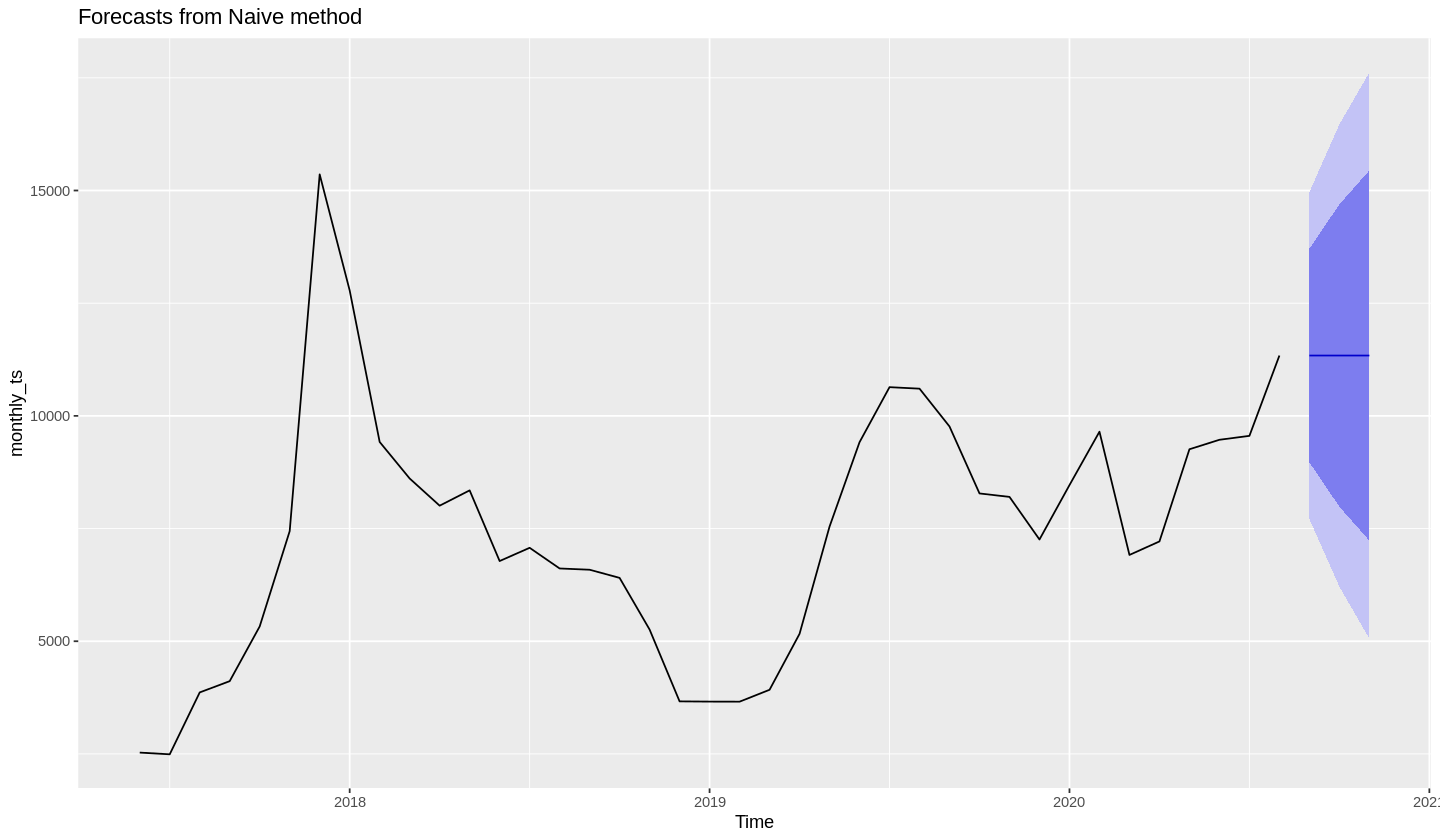

In [17]:
# Plot the monthly timeseries + forecast
autoplot(xbt.fcast)

Naive method makes forecast by taking the most recent value.

### 2.3. Linear Regression - `lm` Function


**Description**
`lm()` is a function used to fit a linear regression

**Function Arguments**

* **formula**: an object of class "formula" to describe the model. Can take the form y~x where y is dependent variable and x is independent variable.
* **data**: an optional data frame, list or environment (or object coercible by as.data.frame to a data frame) containing the variables in the model.
* **subset**: an optional vector specifying a subset of observations to be used in the fitting process.
* **weights**: an optional vector of weights to be used in the fitting process. Should be NULL or a numeric vector. If non-NULL, weighted least squares is used with weights (that is, minimizing sum(w*e^2)); otherwise ordinary least squares is used.
* **na.action**: a function which indicates what should happen when the data contain NAs.
* **method**: the method to be used for fitting.
* ...


For this exercise we want to use monthly data. So we are going to change the frequency of the data from daily to monthly. We need to create two temporary time series datasets and merge them to create a single `crypto_reg` dataset. The two cryptocurrencies will be used are ETH and XBT.

In [18]:
# Extract prices of ETH from main dataset
# convert to numeric type using as.numeric()
eth_price = as.numeric(kraken_df[kraken_df$crypto == "ETH",]$price)

# Extract datetime from main dataset
eth_date = kraken_df[kraken_df$crypto == "ETH",]$datetime

# Calculate z-score of ETH daily prices 
# This is standardization, to better compare with XBT prices
eth_zscore = (eth_price - mean(eth_price)) / sd(eth_price)

# Create index of POSIXct time format and order by time
eth_dt = strptime(x = eth_date, format = "%Y-%m-%d %H:%M:%S")
eth_zscore = xts(eth_zscore, order.by = as.POSIXct(eth_dt))

In [19]:
# Transform into monthly series by taking mean value of each month
eth_zscore = apply.monthly(eth_zscore, mean)

# Create ETH standardized monthly prices timeseries
eth_start = c(year(eth_date[length(eth_date)]),
              month(eth_date[length(eth_date)]))

eth_end = c(year(eth_date[1]), month(eth_date[1]))

In [20]:
eth_tmp =  ts(data = eth_zscore,
              start = eth_start,
              end = eth_end,
              frequency = 12)

In [21]:
# Extract prices of XBT from main dataset and 
# convert to numeric type using as.numeric()
xbt_price = as.numeric(xbt_xts$price)

# Extract datetime from main dataset
xbt_date = kraken_df[kraken_df$crypto == "XBT",]$datetime

# Calculate z-score of XBT daily prices
# This is standardization, to better compare with ETH prices
xbt_zscore = (xbt_price - mean(xbt_price)) / sd(xbt_price)

# Create index of POSIXct time format and order by time
xbt_dt = strptime(xbt_date,"%Y-%m-%d %H:%M:%S")
xbt_zscore = xts(xbt_zscore, order.by = as.POSIXct(xbt_dt))

In [22]:
# Transform into monthly series by taking mean value of each month
xbt_zscore = apply.monthly(xbt_zscore, mean)

# Create ETH standardized monthly prices timeseries
xbt_end = c(year(xbt_date[1]), month(xbt_date[1]))

xbt_start = c(year(xbt_date[length(xbt_date)]),
              month(xbt_date[length(xbt_date)]))

In [23]:
xbt_tmp = ts(data = xbt_zscore,
             start = xbt_start,
             end = xbt_end,
             frequency = 12)

In [24]:
# Data for linear regression
crypto_reg = cbind(eth = eth_tmp, xbt = xbt_tmp)

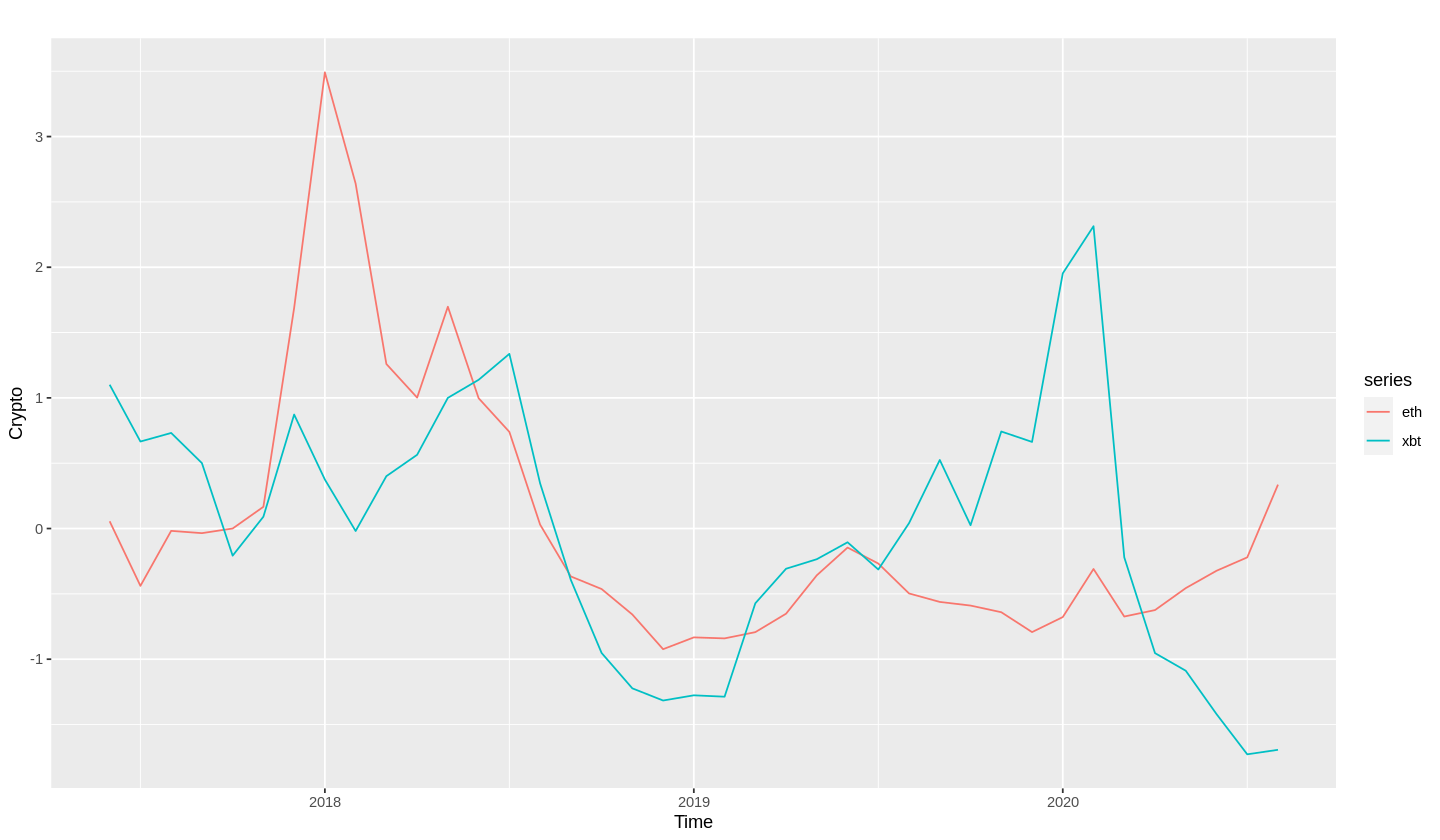

In [25]:
# Plot the 2 timeseries
autoplot(crypto_reg, xlab = "Time", ylab = "Crypto")

In [26]:
# Brief descriptions of the 2 timeseries
summary(crypto_reg)

      eth                xbt           
 Min.   :-0.92339   Min.   :-1.728052  
 1st Qu.:-0.63230   1st Qu.:-0.762273  
 Median :-0.32329   Median : 0.025287  
 Mean   : 0.02422   Mean   : 0.001909  
 3rd Qu.: 0.11096   3rd Qu.: 0.664418  
 Max.   : 3.49130   Max.   : 2.313745  

In [27]:
# Run a linear regression with xbt as dependent variables 
# and eth as independent variables

fit <- lm(xbt ~ eth, data = crypto_reg)
summary(fit)


Call:
lm(formula = xbt ~ eth, data = crypto_reg)

Residuals:
     Min       1Q   Median       3Q      Max 
-1.78807 -0.78093 -0.01489  0.60694  2.41117 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)  
(Intercept) -0.005296   0.152143  -0.035   0.9724  
eth          0.297513   0.155408   1.914   0.0633 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.9498 on 37 degrees of freedom
Multiple R-squared:  0.09013,	Adjusted R-squared:  0.06553 
F-statistic: 3.665 on 1 and 37 DF,  p-value: 0.06333


R-squared are very low, thus movement in ETH prices cannot explain movement in XBT prices very well.

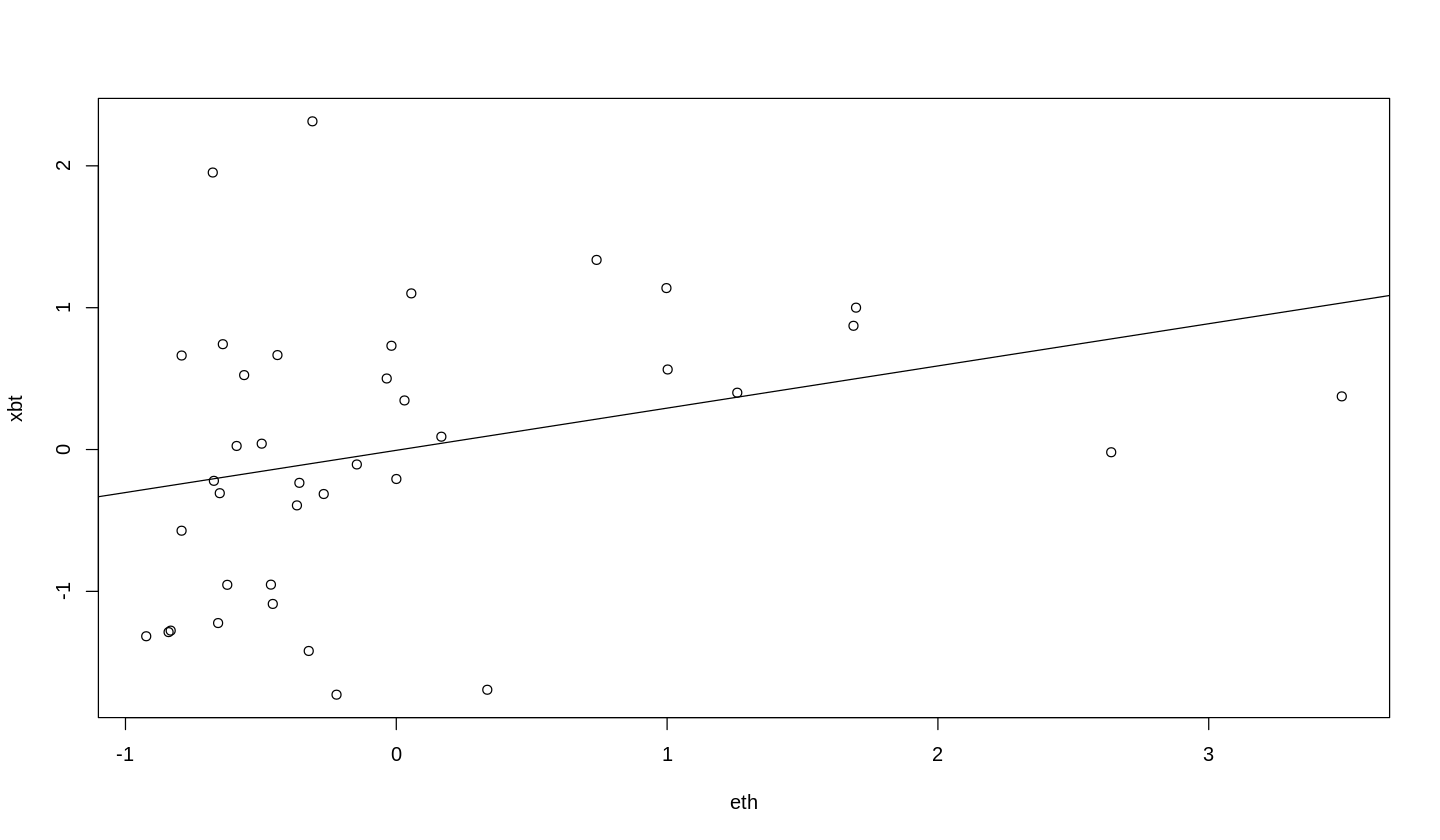

In [28]:
# Scatter plot of the 2 timeseries
plot(xbt ~ eth, data = crypto_reg)

# Plot regression line
abline(fit)

The regression line can somewhat correctly capture the general trend, but residual errors are very high.

## 2.2 Moving Averages - `ma` Function

**Description**
`ma()` computes simple average smoother of a given timeseries

**Function Arguments**

* **x**: univariate timeseries.
* **order**: order of moving average smoother.
* **centre**: If TRUE, then the moving average is centred for even orders.


The Gold Spot price is quoted as US Dollars per Troy Ounce.  Gold Cross rates are available using XAU followed by 3-character ISO code of the cross currency.

In [29]:
# Read XAU prices data file
xau_df = read_csv("data/XAU_USD.csv")

Parsed with column specification:
cols(
  date = col_character(),
  open = col_double(),
  high = col_double(),
  low = col_double(),
  close = col_double()
)



In [30]:
# Reformat date column as Date type Month/Date/Year
xau_df$date = as.Date(xau_df$date, format = "%m/%d/%y")

# Inspect the first few rows
head(xau_df)

date,open,high,low,close
<date>,<dbl>,<dbl>,<dbl>,<dbl>
2020-06-26,1763.78,1772.14,1747.62,1771.29
2020-06-25,1761.17,1768.88,1755.51,1763.79
2020-06-24,1768.41,1779.53,1760.67,1761.17
2020-06-23,1754.43,1771.14,1747.47,1768.41
2020-06-22,1751.51,1763.38,1742.46,1754.43
2020-06-19,1722.93,1745.26,1721.79,1743.87


In [31]:
# Dimention (rows x columns) of the DataFrame
dim_desc(xau_df)

[1] "[11,664 x 5]"

In [32]:
# Create a Datetime index for the DataFrame
xau_xts = xts(select(xau_df,-c("date")),
             order.by = as.POSIXct(strptime(xau_df$date,"%Y-%m-%d")))

# Get year and month of first/last observation
xau_start = c(year(xau_df$date[length(xau_df$date)]),
              month(xau_df$date[length(xau_df$date)]))

xau_end = c(year(xau_df$date[1]), month(xau_df$date[1]))

In [33]:
# Create XAU daily prices timeseries
xau_ts = ts(data = xau_xts,
            start = xau_start,
            end = xau_end,
            frequency = 365)

In [34]:
# Inspect the last few rows
tail(xau_ts)

,open,high,low,close
2020.000,1722.93,1745.26,1721.79,1743.87
2020.003,1751.51,1763.38,1742.46,1754.43
2020.005,1754.43,1771.14,1747.47,1768.41
2020.008,1768.41,1779.53,1760.67,1761.17
2020.011,1761.17,1768.88,1755.51,1763.79
2020.014,1763.78,1772.14,1747.62,1771.29


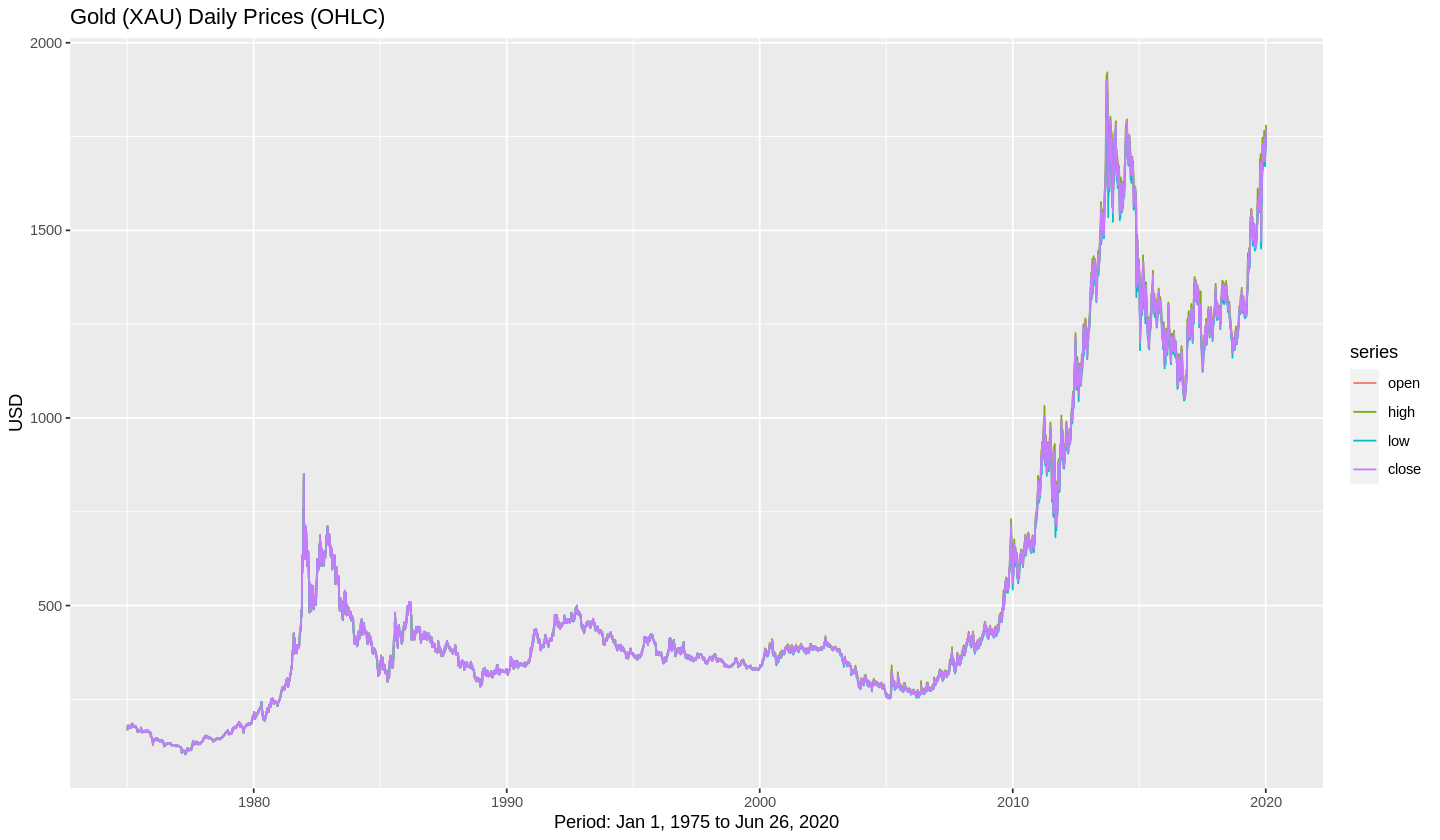

In [35]:
# Plot the timeseries
autoplot(xau_ts, facets = FALSE) +
    ggtitle("Gold (XAU) Daily Prices (OHLC)") +
    xlab("Period: Jan 1, 1975 to Jun 26, 2020") +
    ylab("USD")

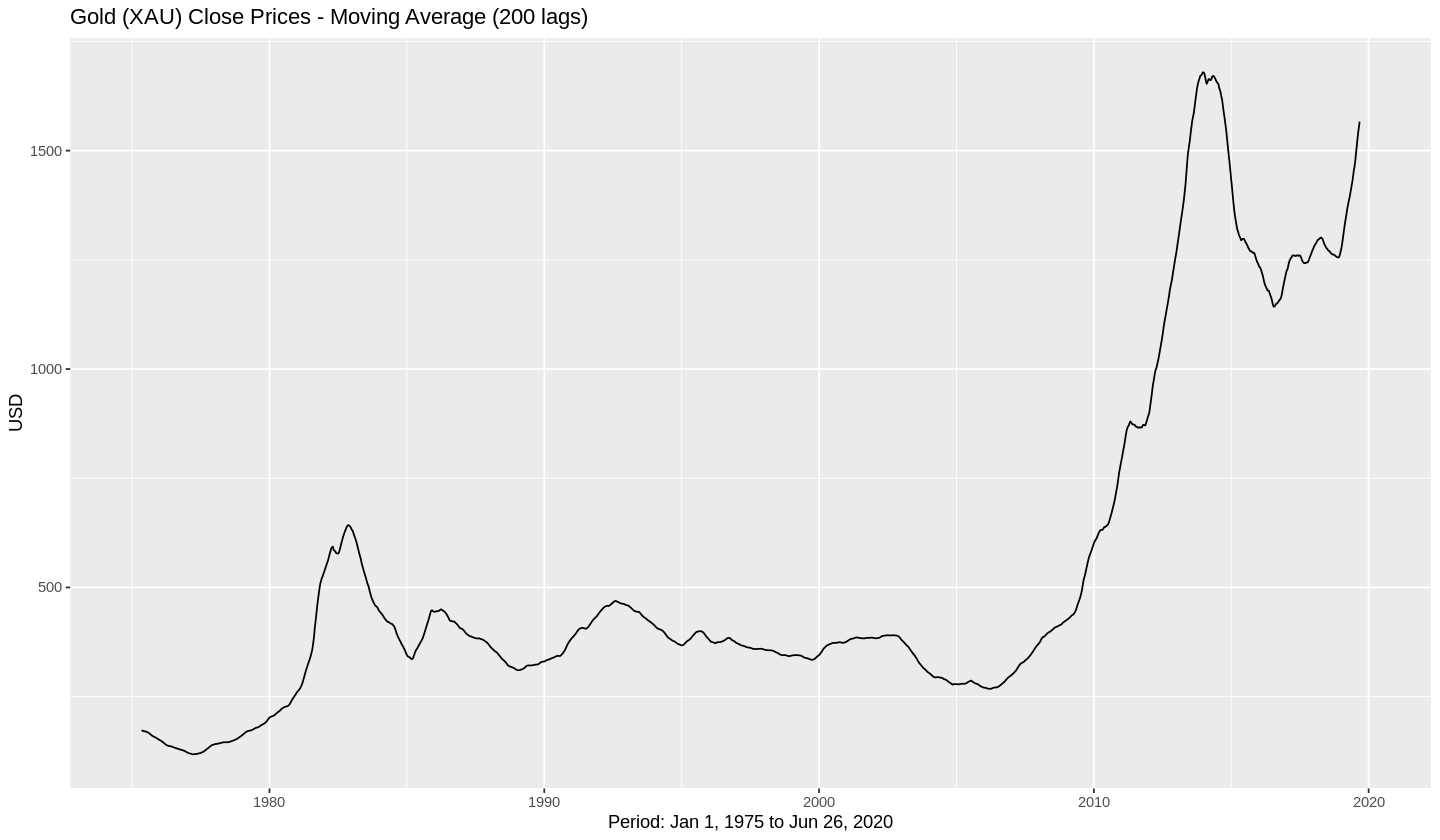

In [36]:
# Calculate Close prices moving average of order 250
xau_250lags = ma(xau_ts[,'close'], 250)

# Plot 250 lags moving average
autoplot(xau_250lags) +
    ggtitle("Gold (XAU) Close Prices - Moving Average (200 lags)") +
    xlab("Period: Jan 1, 1975 to Jun 26, 2020") +
    ylab("USD")

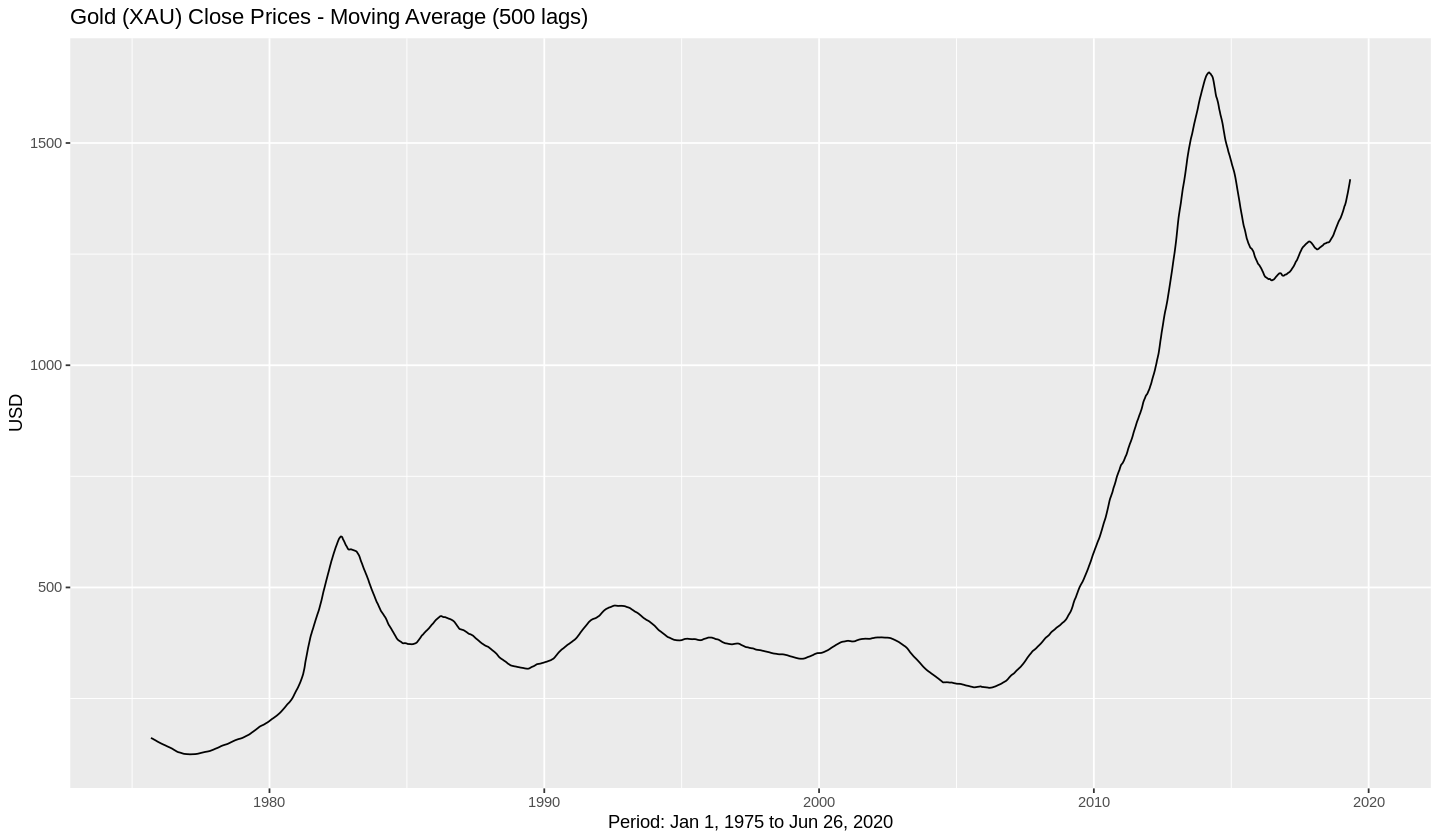

In [37]:
# Calculate Close prices moving average of order 500
xau_500lags = ma(xau_ts[,'close'], 500)

# Plot 500 lags moving average
autoplot(xau_500lags) +
    ggtitle("Gold (XAU) Close Prices - Moving Average (500 lags)") +
    xlab("Period: Jan 1, 1975 to Jun 26, 2020") +
    ylab("USD")

Simple moving average of order 500 is smoother than of order 250 as expected

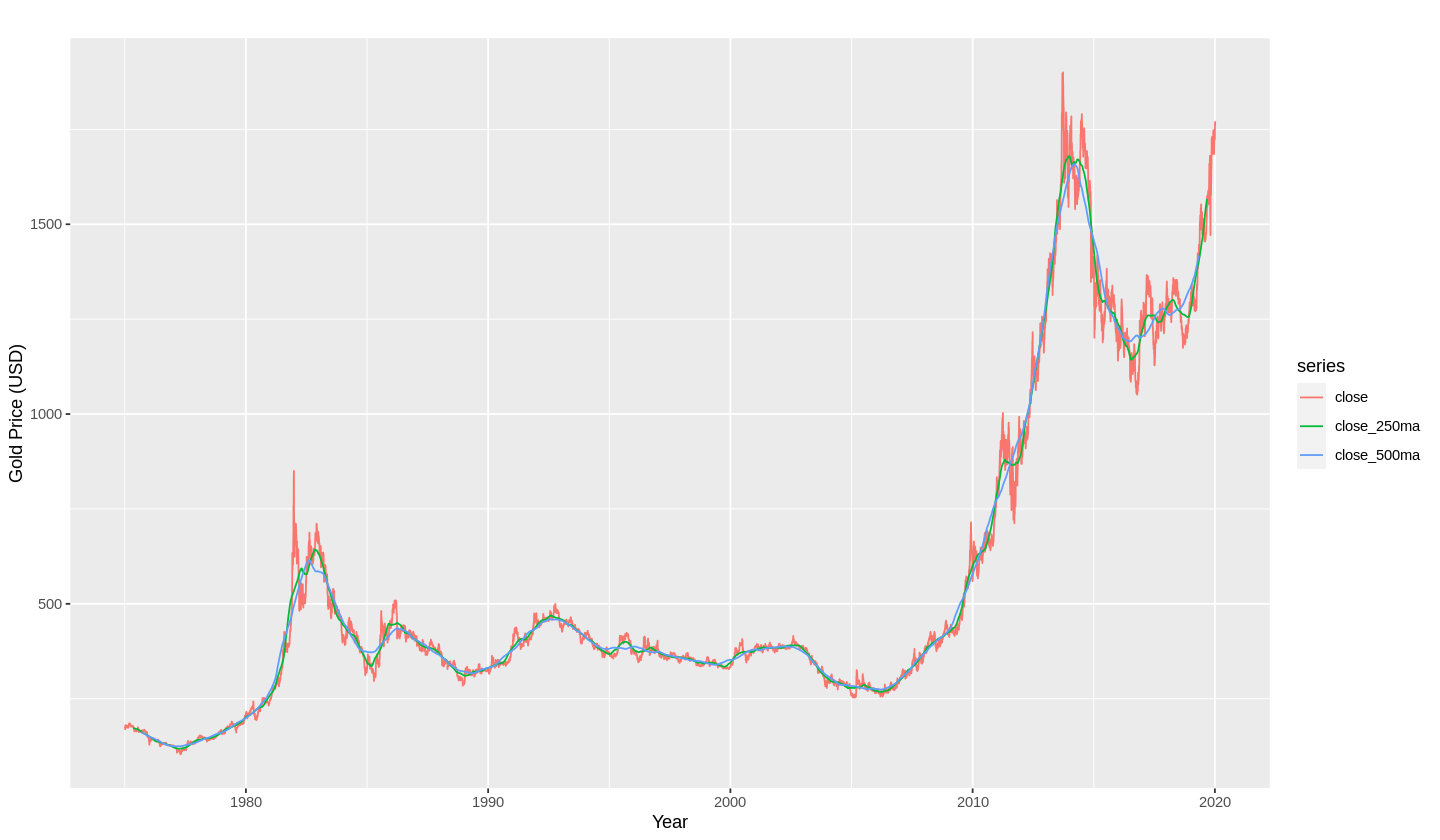

In [38]:
# Combind Close prices with the 2 moving average
xau_ma = cbind("close" = xau_ts[,'close'], 
               "close_250ma" = xau_250lags, 
               "close_500ma" = xau_500lags)

# Plot Close prices with both moving average in the same plot
autoplot(xau_ma, ylab = "Gold Price (USD)", xlab = "Year", facets = FALSE)

Here we can see how moving average smoothens the timeseries: the larger order k is, the smoother the series will become.

## 2.3 Exponential Smoothing - `ses` function

**Description**
`ses()` returns simple exponential smoothing forecast and other information of a given timeseries

**Function Arguments**

* **y**: a numeric vector or time series of class ts.
* **h**: number of periods for forecasting.
* **level**: confidence level for prediction intervals.
* **fan**: if TRUE, level is set to seq(51,99,by=3). This is suitable for fan plots.
* **initial**: method used for selecting initial state values. If optimal, the initial values are optimized along with the smoothing parameters using ets. If simple, the initial values are set to values obtained using simple calculations on the first few observations.
* **alpha**: value of smoothing parameter for the level. If NULL, it will be estimated.
* **lambda**: Box-Cox transformation parameter. If lambda="auto", then a transformation is automatically selected using BoxCox.lambda. The transformation is ignored if NULL. Otherwise, data transformed before model is estimated.
* **damped**: if TRUE, use a damped trend.
* **exponential**: if TRUE, an exponential trend is fitted. Otherwise, the trend is (locally) linear.
* **beta**: value of smoothing parameter for the trend. If NULL, it will be estimated.
* **phi**: value of damping parameter if damped=TRUE. If NULL, it will be estimated.
* **seasonal**: type of seasonality in hw model. "additive" or "multiplicative"
* **gamma**: value of smoothing parameter for the seasonal component. If NULL, it will be estimated.

In [39]:
# Get monthly Close prices of XAU 
# from 2010-01-01 to 2020-06-26 (10 yrs) by taking average of each month
xau_10 = apply.monthly(xau_xts[,'close'], mean)["2010-01-01/2020-06-26"]

# Get datetime index of first and last observation
start_date = index(xau_10)[1]
end_date = index(xau_10[length(xau_10)])

# Get year and month of first and last observation
xau_start = c(year(start_date), month(start_date))
xau_end = c(year(end_date), month(end_date))

In [40]:
# Create a monthly Close prices timeseries
xau_10yrs = ts(data = xau_10,
               start = xau_start,
               end = xau_end,
               frequency = 12)

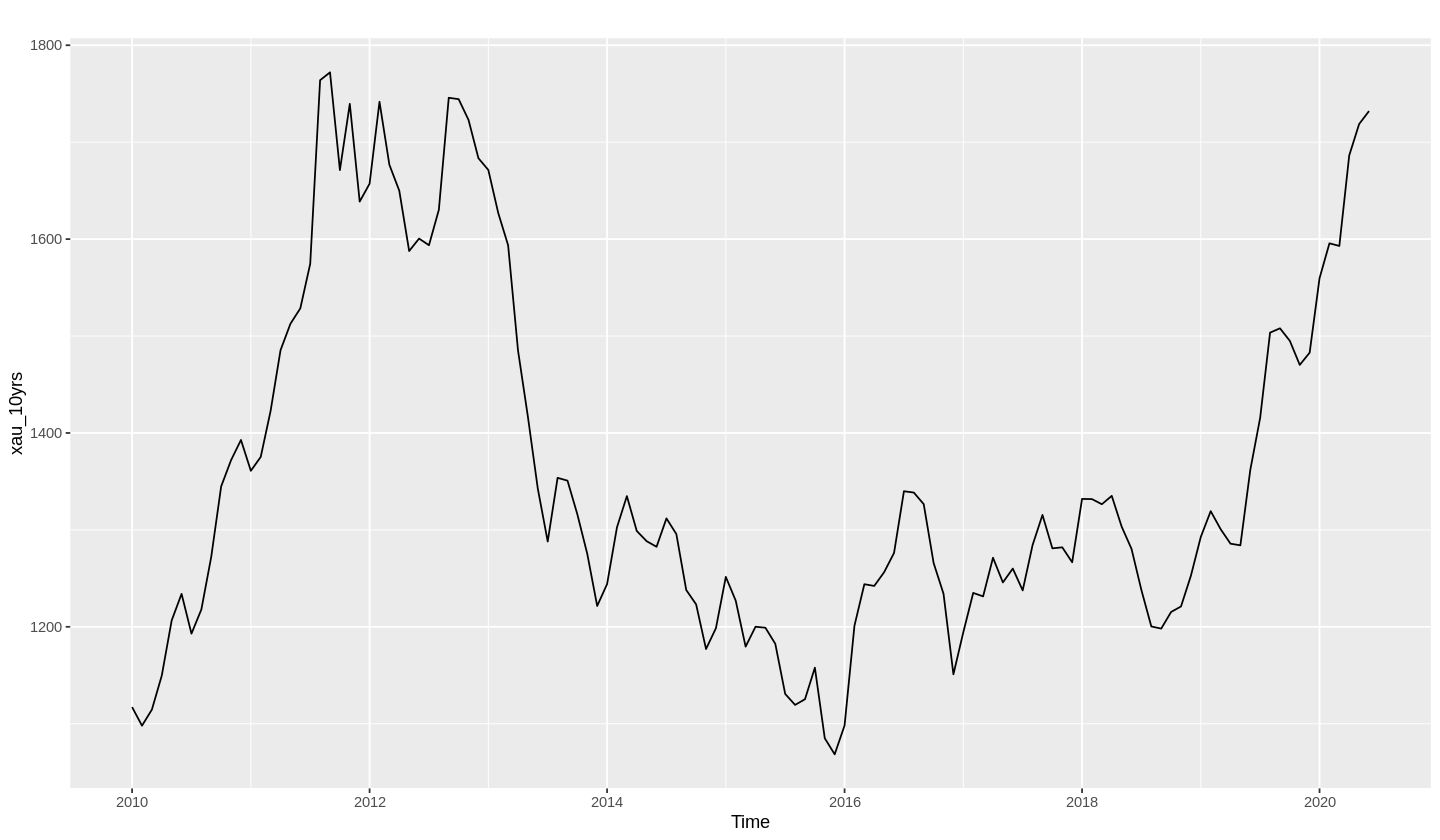

In [41]:
# Plot the 10 yrs monthly Close prices timeseries
autoplot(xau_10yrs)

This data does not have a clear trend or seasonality, so simple exponential smoothing method may perform well.

In [42]:
# First exponential smoothing model: h = 6,
# confidence level of 80% and 95%, alpha = 0.1

xau_ses_01 = ses(y = xau_10yrs,
                 h = 6,
                 level = c(80, 95),
                 alpha = 0.1)

summary(xau_ses_01)


Forecast method: Simple exponential smoothing

Model Information:
Simple exponential smoothing 

Call:
 ses(y = xau_10yrs, h = 6, level = c(80, 95), alpha = 0.1) 

  Smoothing parameters:
    alpha = 0.1 

  Initial states:
    l = 1292.6888 

  sigma:  133.0965

     AIC     AICc      BIC 
1843.906 1844.004 1849.579 

Error measures:
                   ME    RMSE    MAE       MPE     MAPE      MASE     ACF1
Training set 17.07649 132.036 106.74 0.3973158 7.685159 0.6593942 0.913535

Forecasts:
         Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
Jul 2020       1507.853 1337.282 1678.423 1246.988 1768.717
Aug 2020       1507.853 1336.432 1679.273 1245.687 1770.018
Sep 2020       1507.853 1335.585 1680.120 1244.392 1771.313
Oct 2020       1507.853 1334.743 1680.962 1243.104 1772.601
Nov 2020       1507.853 1333.905 1681.801 1241.822 1773.883
Dec 2020       1507.853 1333.070 1682.635 1240.546 1775.159


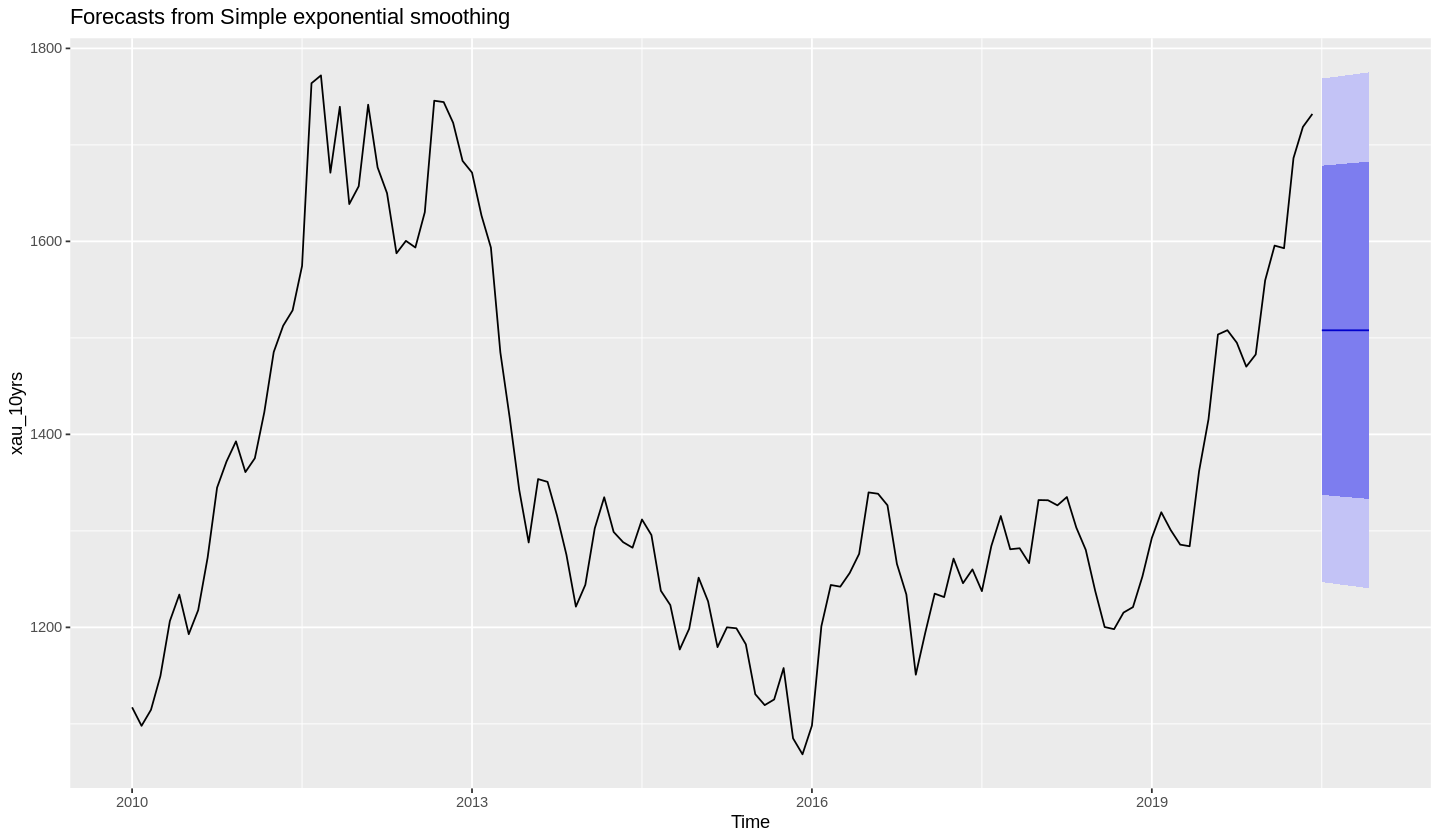

In [43]:
# Plot the first exponential smoothing model
autoplot(xau_ses_01)

In [44]:
# Second exponential smoothing model: h = 6
# confidence level of 80% and 95%, alpha = 0.5

xau_ses_05 = ses(y = xau_10yrs,
                 h = 6,
                 level = c(80, 95),
                 alpha = 0.5)

summary(xau_ses_05)


Forecast method: Simple exponential smoothing

Model Information:
Simple exponential smoothing 

Call:
 ses(y = xau_10yrs, h = 6, level = c(80, 95), alpha = 0.5) 

  Smoothing parameters:
    alpha = 0.5 

  Initial states:
    l = 1120.3536 

  sigma:  61.2512

     AIC     AICc      BIC 
1648.331 1648.429 1654.004 

Error measures:
                   ME     RMSE      MAE       MPE   MAPE      MASE      ACF1
Training set 9.254808 60.76309 46.93542 0.5255014 3.3856 0.2899471 0.6415502

Forecasts:
         Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
Jul 2020       1703.407 1624.910 1781.903 1583.356 1823.457
Aug 2020       1703.407 1615.645 1791.168 1569.186 1837.627
Sep 2020       1703.407 1607.268 1799.545 1556.376 1850.437
Oct 2020       1703.407 1599.565 1807.248 1544.595 1862.218
Nov 2020       1703.407 1592.396 1814.417 1533.630 1873.183
Dec 2020       1703.407 1585.662 1821.151 1523.331 1883.482


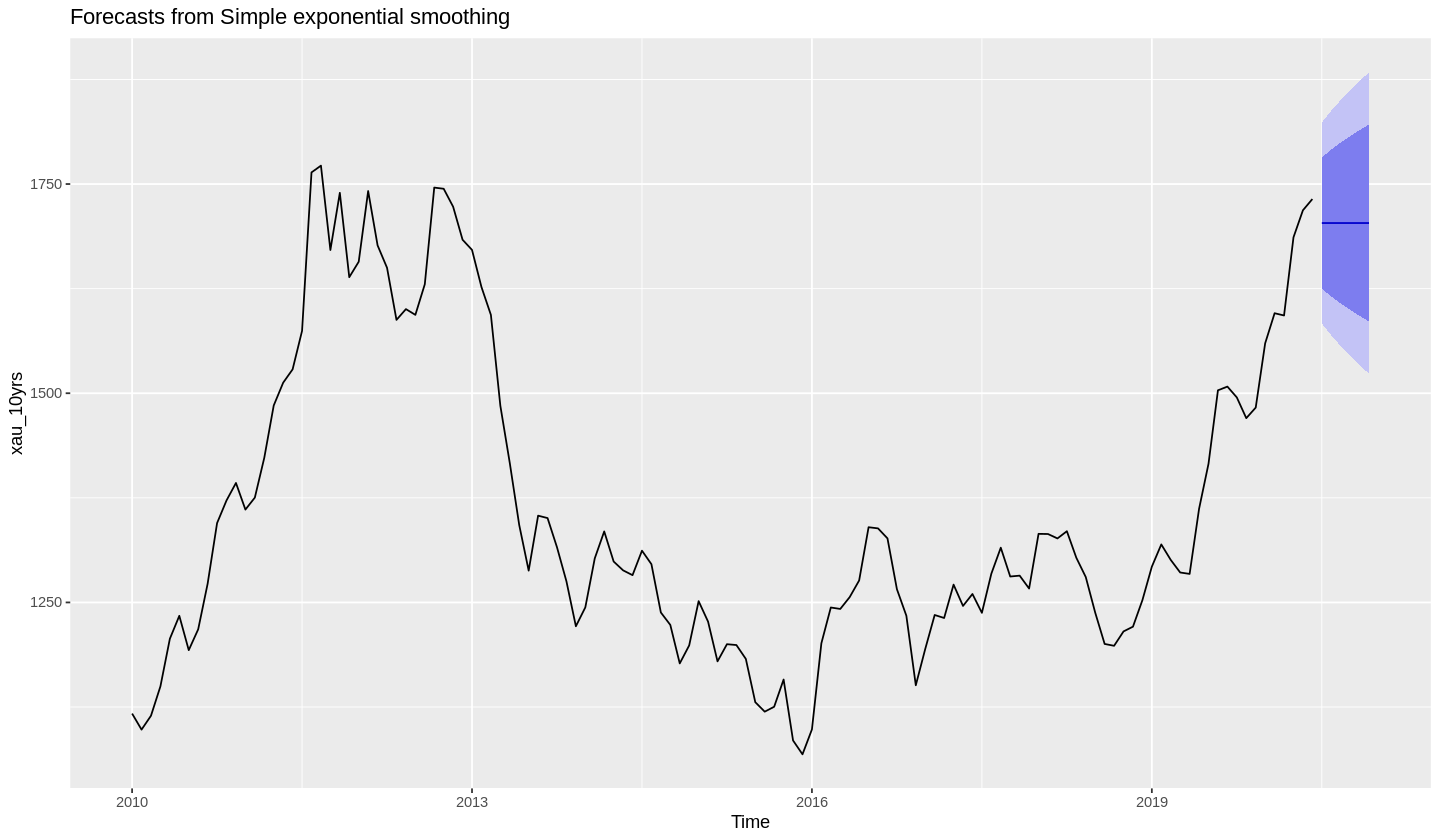

In [45]:
# Plot the second exponential smoothing model
autoplot(xau_ses_05)

In [46]:
# Third exponential smoothing model: h = 6
# confidence level of 80% and 95%, alpha = 0.9

xau_ses_09 = ses(y = xau_10yrs,
                 h = 6,
                 level = c(80, 95),
                 alpha = 0.9)

summary(xau_ses_09)


Forecast method: Simple exponential smoothing

Model Information:
Simple exponential smoothing 

Call:
 ses(y = xau_10yrs, h = 6, level = c(80, 95), alpha = 0.9) 

  Smoothing parameters:
    alpha = 0.9 

  Initial states:
    l = 1115.4531 

  sigma:  48.7837

     AIC     AICc      BIC 
1590.979 1591.077 1596.652 

Error measures:
                   ME   RMSE      MAE       MPE     MAPE      MASE      ACF1
Training set 5.422087 48.395 37.72357 0.3223015 2.740707 0.2330402 0.3182635

Forecasts:
         Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
Jul 2020       1730.318 1667.799 1792.837 1634.703 1825.932
Aug 2020       1730.318 1646.207 1814.428 1601.682 1858.954
Sep 2020       1730.318 1629.122 1831.513 1575.552 1885.083
Oct 2020       1730.318 1614.531 1846.104 1553.238 1907.398
Nov 2020       1730.318 1601.584 1859.052 1533.436 1927.200
Dec 2020       1730.318 1589.824 1870.811 1515.451 1945.184


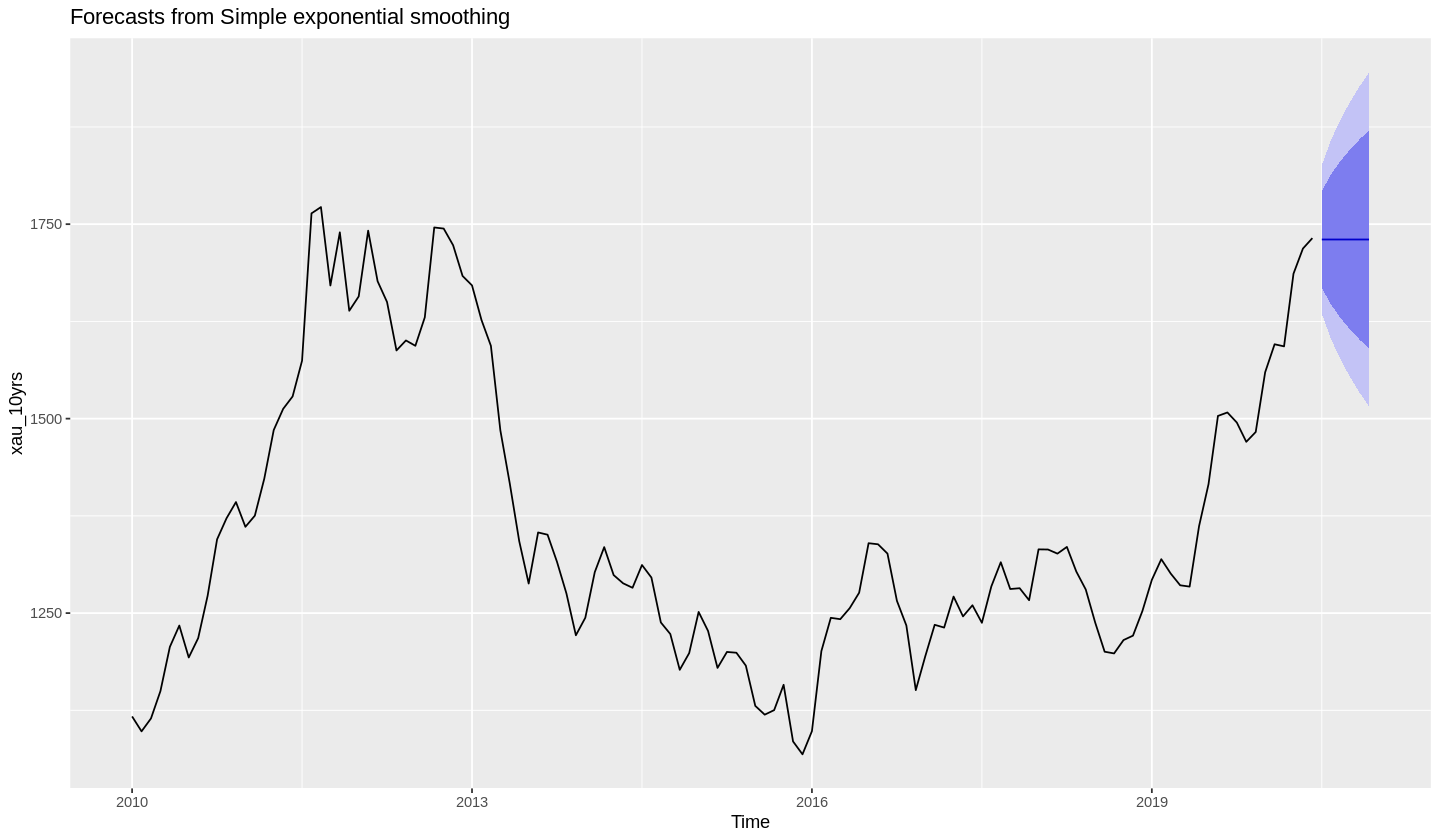

In [47]:
# Plot the third exponential smoothing model
autoplot(xau_ses_09)

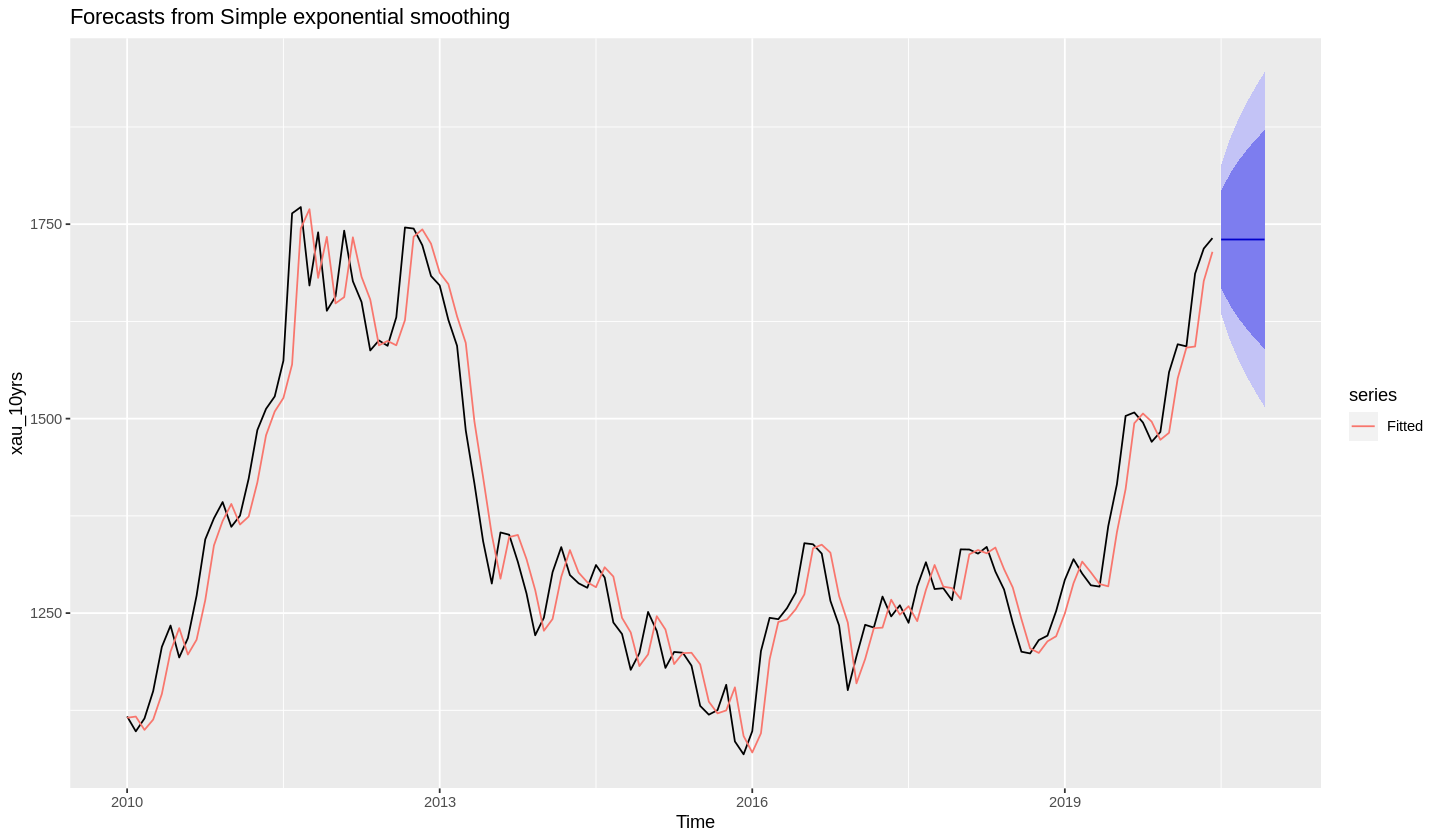

In [48]:
# Add the fitted values
autoplot(xau_ses_09) + autolayer(fitted(xau_ses_09), series = "Fitted")

Of the 3 models, exponential smoothing with alpha = 0.9 has the lowest RMSE. Thus this model is better than the other 2 models.

## 2.4. Holt method - `holt` function

**Description**
`holt()` returns forecast and other information of a given timeseries using Holt method

**Function Arguments**

* **y**: a numeric vector or time series of class ts.
* **h**: number of periods for forecasting.
* **level**: confidence level for prediction intervals.
* **fan**: if TRUE, level is set to seq(51,99,by=3). This is suitable for fan plots.
* **initial**: method used for selecting initial state values. If optimal, the initial values are optimized along with the smoothing parameters using ets. If simple, the initial values are set to values obtained using simple calculations on the first few observations.
* **alpha**: value of smoothing parameter for the level. If NULL, it will be estimated.
* **lambda**: Box-Cox transformation parameter. If lambda="auto", then a transformation is automatically selected using BoxCox.lambda. The transformation is ignored if NULL. Otherwise, data transformed before model is estimated.
* **damped**: if TRUE, use a damped trend.
* **exponential**: if TRUE, an exponential trend is fitted. Otherwise, the trend is (locally) linear.
* **beta**: value of smoothing parameter for the trend. If NULL, it will be estimated.
* **phi**: value of damping parameter if damped=TRUE. If NULL, it will be estimated.
* **seasonal**: type of seasonality in hw model. "additive" or "multiplicative"
* **gamma**: value of smoothing parameter for the seasonal component. If NULL, it will be estimated.

In [49]:
# Get monthly Close prices of XAU
# from 2016-01-01 to 2020-06-26 (5 yrs) by taking average of each month
xau_05 = apply.monthly(xau_xts[,'close'], mean)["2016-01-01/2020-06-26"]

# Get datetime index of first and last observation
start_date = index(xau_05)[1]
end_date = index(xau_05[length(xau_05)])

# Get year and month of first and last observation
xau_start = c(year(start_date), month(start_date))
xau_end = c(year(end_date), month(end_date))


In [50]:
# Create 5 years monthly Close prices timeseries of XAU
xau_5yrs = ts(data = xau_05,
              start = xau_start,
              end = xau_end,
              frequency = 12)

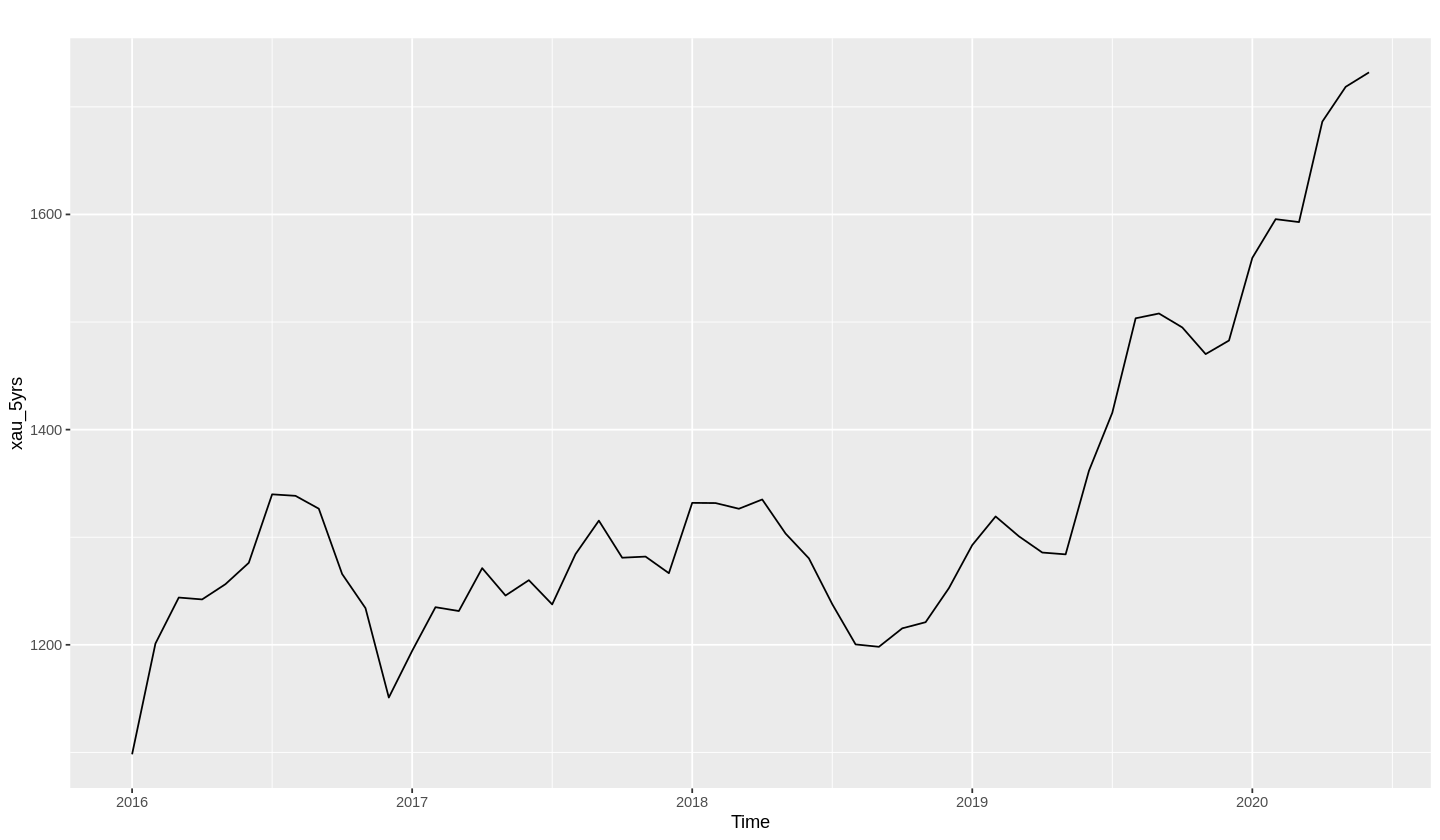

In [51]:
# Plot the timeseries
autoplot(xau_5yrs)

This data clearly has an upward trend, so simple exponential smoothing does not seem to be a good choice. Holt method works well with data with trend.

In [52]:
# Holt method with h = 6
holt_06 = holt(xau_5yrs, h = 6)

summary(holt_06)


Forecast method: Holt's method

Model Information:
Holt's method 

Call:
 holt(y = xau_5yrs, h = 6) 

  Smoothing parameters:
    alpha = 0.9999 
    beta  = 0.0147 

  Initial states:
    l = 1210.5641 
    b = 18.1691 

  sigma:  44.48

     AIC     AICc      BIC 
631.1134 632.3634 641.0583 

Error measures:
                    ME     RMSE      MAE        MPE     MAPE      MASE     ACF1
Training set -4.324149 42.80086 33.35707 -0.4557887 2.567106 0.2706951 0.100081

Forecasts:
         Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
Jul 2020       1746.822 1689.819 1803.826 1659.643 1834.001
Aug 2020       1761.568 1680.364 1842.772 1637.377 1885.758
Sep 2020       1776.313 1676.133 1876.494 1623.100 1929.526
Oct 2020       1791.059 1674.538 1907.579 1612.856 1969.261
Nov 2020       1805.804 1674.587 1937.022 1605.125 2006.484
Dec 2020       1820.550 1675.772 1965.328 1599.132 2041.968


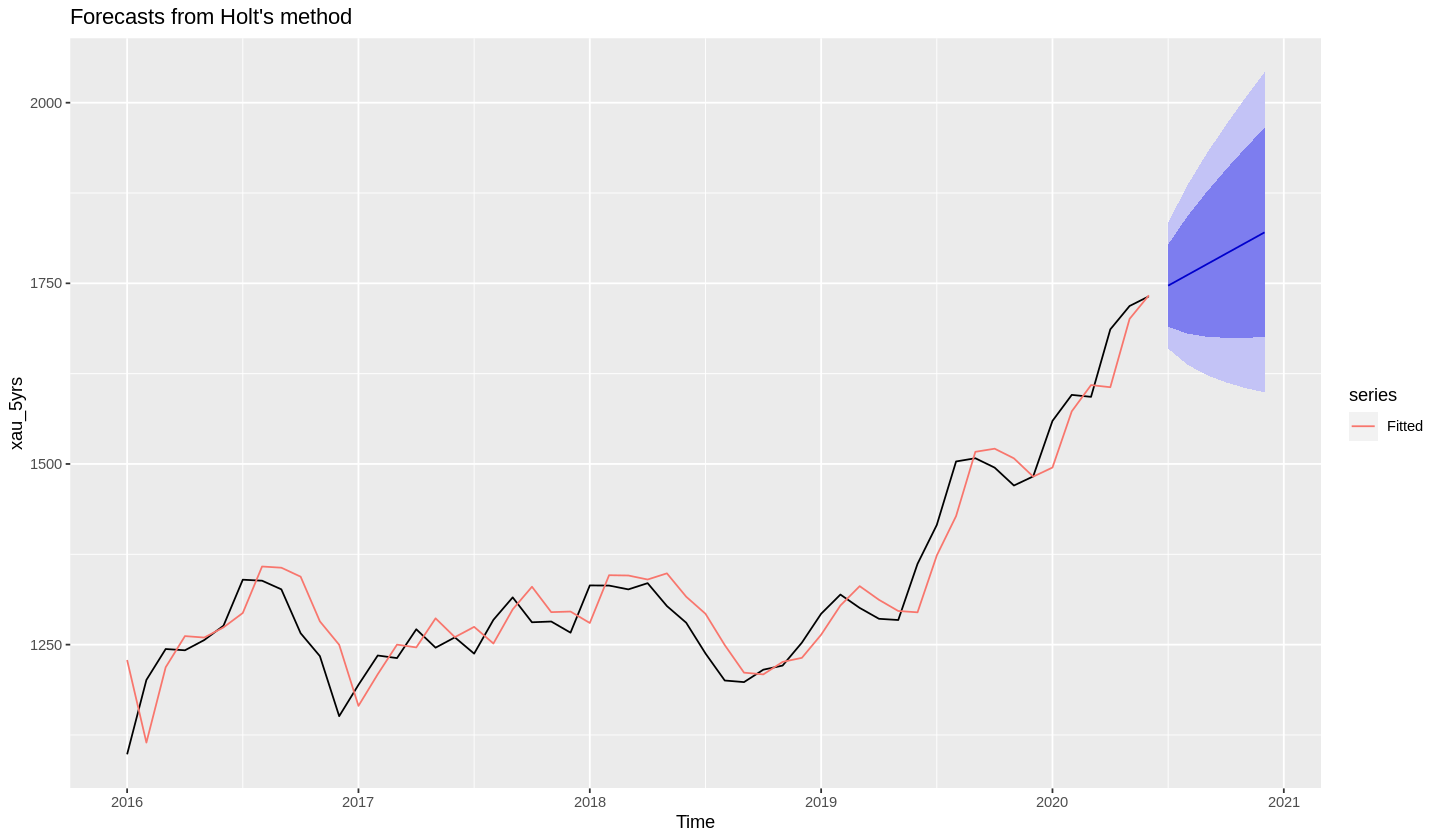

In [53]:
# Plot the model and the fitted values
autoplot(holt_06) + autolayer(fitted(holt_06), series = "Fitted")

Holt method tends to overestimate the trend. Damped Holt method is introduced to damp the trend using parameter phi.

In [54]:
# Damped Holt method with phi = 0.9 and h = 6

holt_damped = holt(xau_5yrs,
                   damped = TRUE,
                   phi = 0.9,
                   h = 6)

summary(holt_damped)


Forecast method: Damped Holt's method

Model Information:
Damped Holt's method 

Call:
 holt(y = xau_5yrs, h = 6, damped = TRUE, phi = 0.9) 

  Smoothing parameters:
    alpha = 0.9999 
    beta  = 0.147 
    phi   = 0.9 

  Initial states:
    l = 1058.9044 
    b = 31.4249 

  sigma:  40.1641

     AIC     AICc      BIC 
618.9993 620.2493 628.9443 

Error measures:
                   ME     RMSE      MAE       MPE     MAPE      MASE      ACF1
Training set 4.537829 38.25945 30.98215 0.2896274 2.342626 0.2514225 0.1598427

Forecasts:
         Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
Jul 2020       1749.969 1698.497 1801.441 1671.249 1828.689
Aug 2020       1766.072 1688.317 1843.826 1647.157 1884.987
Sep 2020       1780.564 1679.598 1881.530 1626.150 1934.979
Oct 2020       1793.607 1670.792 1916.423 1605.777 1981.438
Nov 2020       1805.346 1661.499 1949.194 1585.350 2025.343
Dec 2020       1815.911 1651.625 1980.198 1564.657 2067.166


We can see that Damped Holt method with phi = 0.9 the model has a lower RMSE. Thus this is a better model.

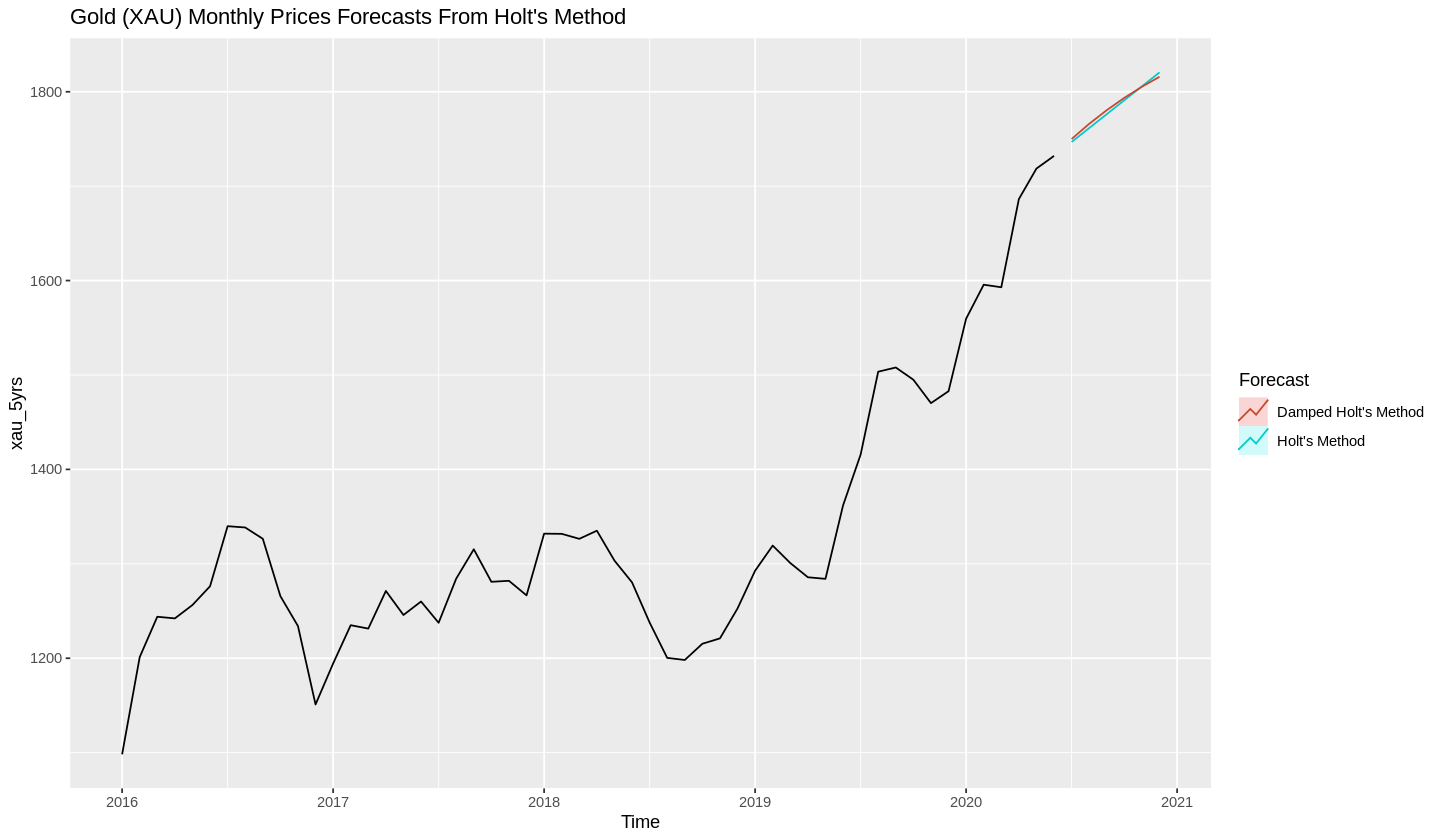

In [55]:
# PLot the 5 years timeseries, Holt method and Damped Holt method
autoplot(xau_5yrs) +
    autolayer(holt_06, series = "Holt's Method", PI = FALSE) + 
    autolayer(holt_damped, series = "Damped Holt's Method", PI = FALSE) +
    ggtitle("Gold (XAU) Monthly Prices Forecasts From Holt's Method") + 
    guides(colour = guide_legend(title="Forecast"))

Damped Holt method reduce overestimation of trend.

## 2.5. Holt-Winters method - `hw` function

**Description**
`hw()` returns forecast and other information of a given timeseries using Holt-Winters method. Holt-Winters method introduce seasonality into the model (as compared to Holt method).

**Function Arguments**

* **y**: a numeric vector or time series of class ts.
* **h**: number of periods for forecasting.
* **level**: confidence level for prediction intervals.
* **fan**: if TRUE, level is set to seq(51,99,by=3). This is suitable for fan plots.
* **initial**: method used for selecting initial state values. If optimal, the initial values are optimized along with the smoothing parameters using ets. If simple, the initial values are set to values obtained using simple calculations on the first few observations.
* **alpha**: value of smoothing parameter for the level. If NULL, it will be estimated.
* **lambda**: Box-Cox transformation parameter. If lambda="auto", then a transformation is automatically selected using BoxCox.lambda. The transformation is ignored if NULL. Otherwise, data transformed before model is estimated.
* **damped**: if TRUE, use a damped trend.
* **exponential**: if TRUE, an exponential trend is fitted. Otherwise, the trend is (locally) linear.
* **beta**: value of smoothing parameter for the trend. If NULL, it will be estimated.
* **phi**: value of damping parameter if damped=TRUE. If NULL, it will be estimated.
* **seasonal**: type of seasonality in hw model. "additive" or "multiplicative"
* **gamma**: value of smoothing parameter for the seasonal component. If NULL, it will be estimated.

In [56]:
# Get monthly Close prices of XAU
# from 2017-01-01 to 2020-06-26 (4 yrs) by taking average of each months 
xau_04 = apply.monthly(xau_xts[,'close'], mean)["2017-01-01/2020-01-01"]

# Get datetime index of first and last observaion
start_date = index(xau_04)[1]
end_date = index(xau_04[length(xau_04)])

# Gest year and month of first and last observation
xau_start = c(year(start_date), month(start_date))
xau_end = c(year(end_date), month(end_date))


In [57]:
# Create 4 years monthly Close prices timeseries
xau_4yrs = ts(data = xau_04,
              start = xau_start,
              end = xau_end,
              frequency = 12)

In [58]:
# Additive Holt-Winter method
xau_hw01 = hw(xau_4yrs, seasonal = "additive")

# Multiplicative Holt-Winter method
xau_hw02 = hw(xau_4yrs, seasonal = "multiplicative")

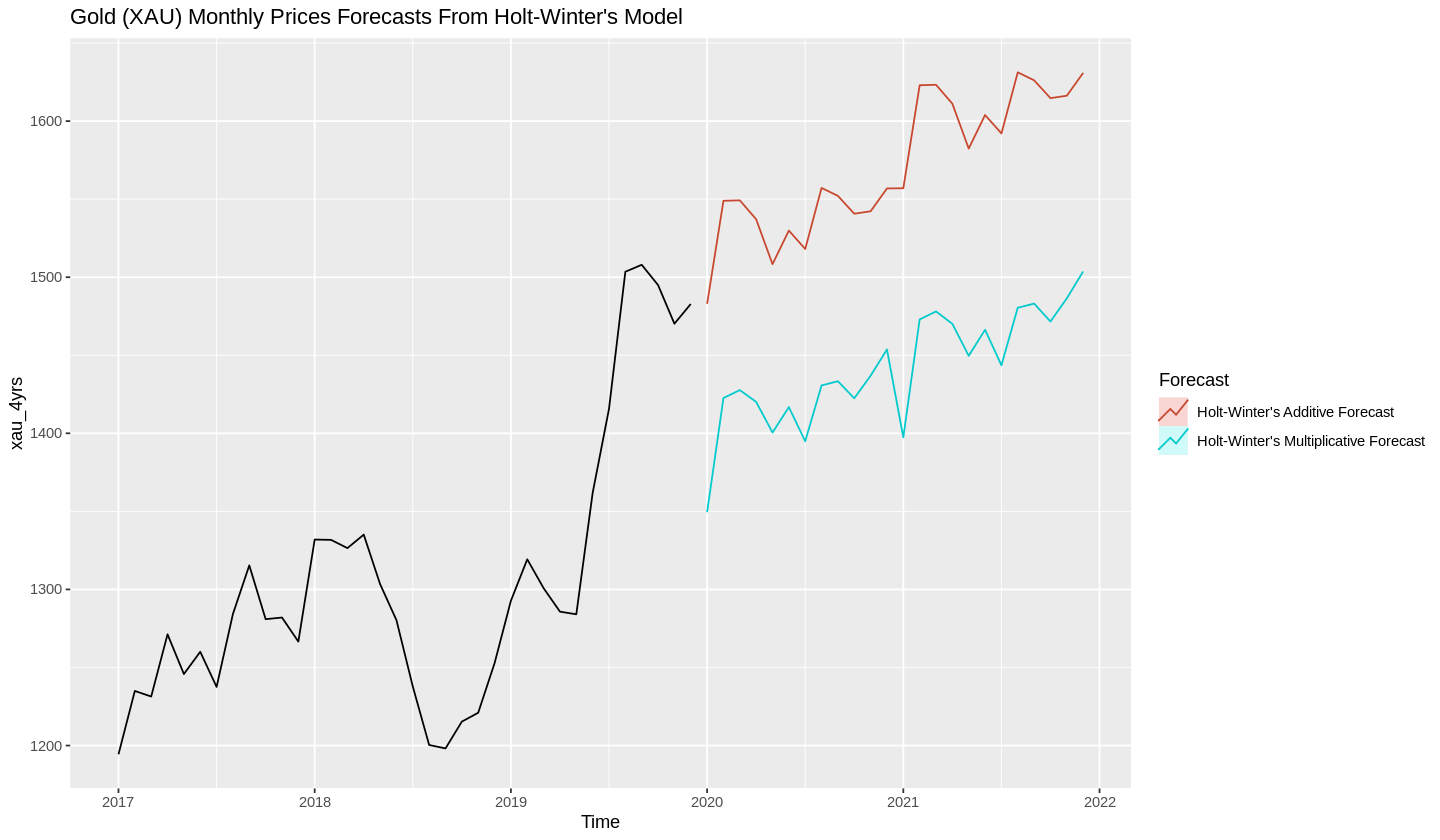

In [59]:
# Plot the timeseries, Holt-Winter additive and multiplicative method
autoplot(xau_4yrs) +
    autolayer(xau_hw01, series = "Holt-Winter's Additive Forecast", PI = FALSE) + 
    autolayer(xau_hw02, series = "Holt-Winter's Multiplicative Forecast", PI = FALSE) +
    ggtitle("Gold (XAU) Monthly Prices Forecasts From Holt-Winter's Model") + 
    guides(colour = guide_legend(title="Forecast"))

Holt-Winters additive method is useful when seasonal variation is constant, while multiplicative method is usefull when seasonal variation changes in proportion to the level of the timeseries. It's hard to see which model is better using the graph, so we need to look in to RMSE.

In [60]:
# Summary of additive method
print(summary(xau_hw01))

# Summary of multiplicative method
print(summary(xau_hw02))


Forecast method: Holt-Winters' additive method

Model Information:
Holt-Winters' additive method 

Call:
 hw(y = xau_4yrs, seasonal = "additive") 

  Smoothing parameters:
    alpha = 0.9987 
    beta  = 0.0001 
    gamma = 0.0012 

  Initial states:
    l = 1251.9573 
    b = 6.1662 
    s = -12.3419 -20.802 -16.2186 1.3039 12.6618 -20.3489
           -2.3471 -17.7216 17.153 35.5703 41.5694 -18.4783

  sigma:  46.0658

     AIC     AICc      BIC 
417.6115 451.6115 444.5314 

Error measures:
                    ME     RMSE      MAE          MPE     MAPE      MASE
Training set 0.5987857 34.33546 26.38697 -0.004297153 2.023468 0.2444932
                  ACF1
Training set 0.1707572

Forecasts:
         Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
Jan 2020       1482.956 1423.920 1541.992 1392.669 1573.243
Feb 2020       1548.936 1465.494 1632.377 1421.323 1676.549
Mar 2020       1549.234 1447.054 1651.413 1392.963 1705.504
Apr 2020       1537.107 1419.125 1655.089 1356.669 1717.54

Holt-Winters additive method has a much lower RMSE, thus this is the better model.

## 2.5. Autoregression - `arima` function

WTI CL1 represents the price of the 1st future (that closest to expiration at any given point in time) subject to certain rules on when they change to the next contract.

NYMEX WTI Crude Oil futures (CL), the world’s most liquid crude oil contract. When traders need the current oil price, they check the WTI Crude Oil price. WTI (West Texas Intermediate, a US light sweet crude oil blend) futures provide direct crude oil exposure and are the most efficient way to trade oil after a sharp rise in US crude oil production.

* https://www.cmegroup.com/trading/energy/crude-oil/light-sweet-crude.html

**NOTE:** WTI CL1 traded negative on Monday, April 04 2020

**Description**
`arima()` fits an ARIMA model to a univariate time series. We will learn more detail about ARIMA model in module 3. Here we only need fit an Autoregressive model. An AR(p) model is an ARIMA(p,0,0) model.

**Function Arguments**
arima(x, order = c(p,0,0))
* **x**: a numeric vector or time series of class ts.
* **order**: order of ARIMA model. p is the order of Autoregressive model.

In [61]:
# Read the dataset
wti_df = read_csv("data/WTI_CL1.csv")

Parsed with column specification:
cols(
  date = col_character(),
  open = col_double(),
  high = col_double(),
  low = col_double(),
  close = col_double()
)



In [62]:
# Convert the column date to Date format Month/Date/Year
wti_df$date = as.Date(wti_df$date, format = "%m/%d/%y")
head(wti_df)

date,open,high,low,close
<date>,<dbl>,<dbl>,<dbl>,<dbl>
2020-06-26,39.09,39.35,37.79,38.49
2020-06-25,38.05,39.23,37.08,38.72
2020-06-24,39.99,40.54,37.31,38.01
2020-06-23,40.68,41.63,39.76,40.37
2020-06-22,39.18,40.70,39.12,40.46
2020-06-19,38.85,40.49,38.40,39.75


In [63]:
# Dimention of the DataFrame (rows x columns)
dim_desc(wti_df)

[1] "[8,924 x 5]"

In [64]:
# Create a Datetime index for the DataFrame
wti_xts = xts(select(wti_df,-c("date")),
              order.by = as.POSIXct(strptime(wti_df$date,"%Y-%m-%d")))

In [65]:
# Get monthly Close prices of WTI
# from 2016-01-01 to 2020-06-26 (5 yrs) by taking average of each month 
wti_05 = apply.monthly(wti_xts[,'close'], mean)["2016-01-01/2020-06-26"]

# Get datetime index of first and last observation
start_date = index(wti_05)[1]
end_date = index(wti_05[length(wti_05)])

# Get year and month of first and last observation
wti_start = c(year(start_date), month(start_date))
wti_end = c(year(end_date), month(end_date))

In [66]:
# Creat 5 years monthly Close prices time series of WTI
wti_5yrs = ts(data = wti_05,
              start = wti_start,
              end = wti_end,
              frequency = 12)

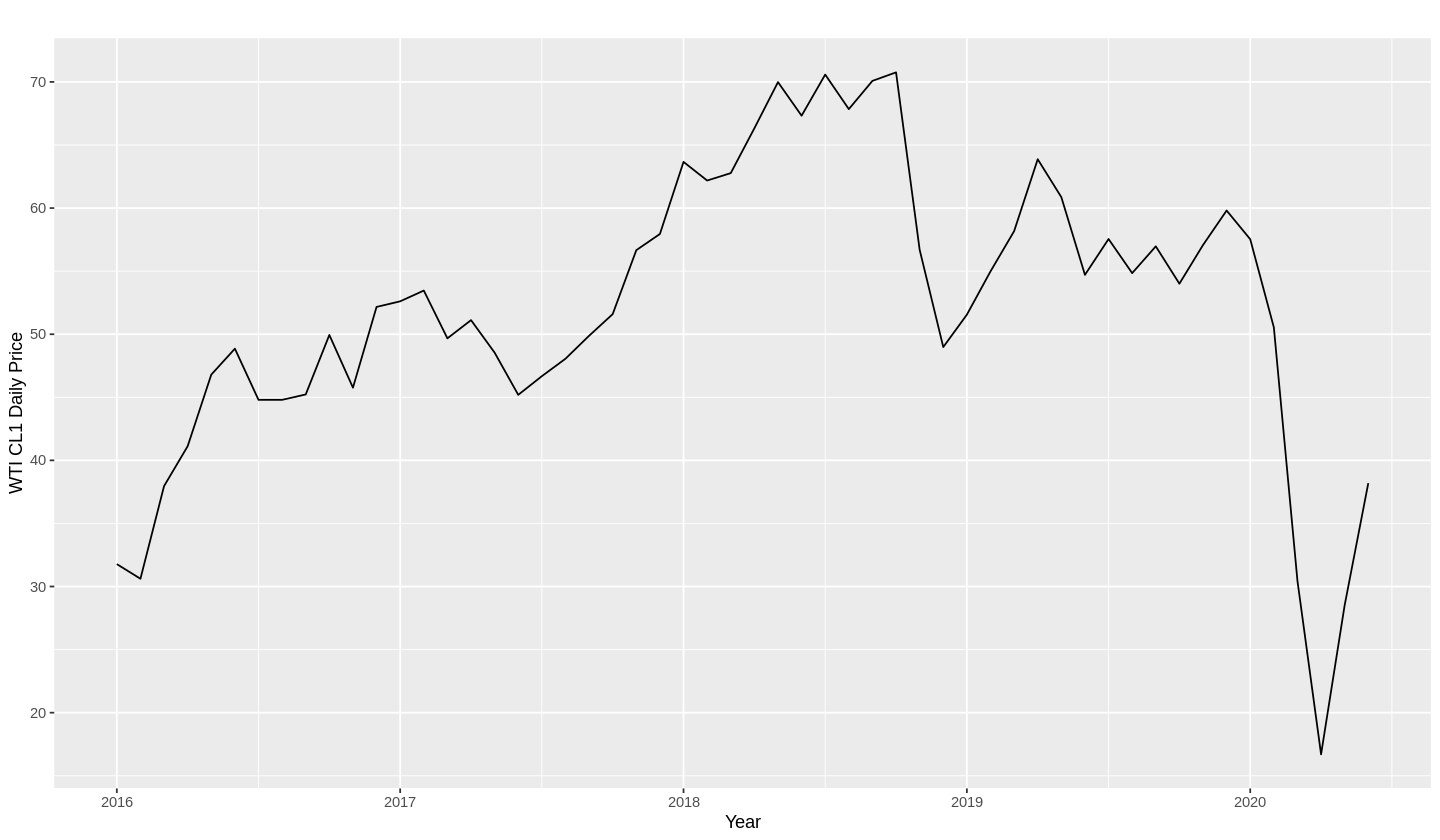

In [67]:
# Plot the timeseries
autoplot(wti_5yrs, ylab = "WTI CL1 Daily Price", xlab = "Year")

### AR(1) - Autoregressive Model - `arima` function

In [68]:
# AR(1) Model on 5 years WTI CL1 monthly prices 
ar01_fit = arima(wti_5yrs, order = c(1,0,0))
summary(ar01_fit)


Call:
arima(x = wti_5yrs, order = c(1, 0, 0))

Coefficients:
         ar1  intercept
      0.8957    47.9855
s.e.  0.0610     6.5188

sigma^2 estimated as 29.65:  log likelihood = -168.95,  aic = 343.89

Training set error measures:
                  ME     RMSE      MAE       MPE    MAPE      MASE      ACF1
Training set 0.43618 5.444913 4.089824 -1.017549 9.87886 0.9953191 0.2987184


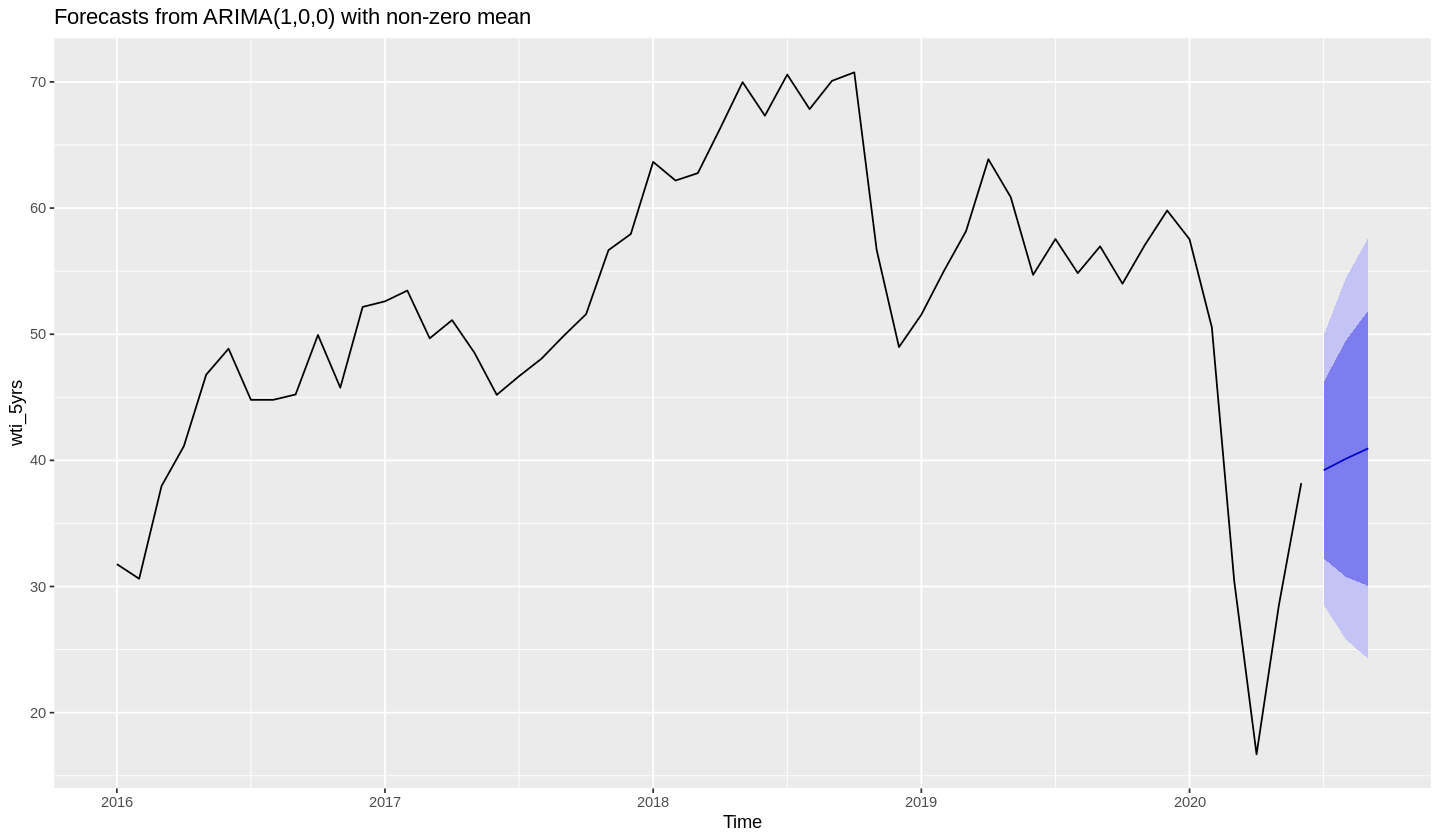

In [69]:
# Forecast 3 periods into the future
forward = forecast(ar01_fit, h = 3)

# Plot the model
autoplot(forward)

### AR(2) - Autoregressive Model

In [70]:
# AR(2) Model on 5 years WTI CL1 monthly prices 
ar02_fit = arima(wti_5yrs, order = c(2,0,0))
summary(ar02_fit)


Call:
arima(x = wti_5yrs, order = c(2, 0, 0))

Coefficients:
         ar1      ar2  intercept
      1.2312  -0.4071    51.1681
s.e.  0.1264   0.1372     3.8553

sigma^2 estimated as 25.42:  log likelihood = -164.89,  aic = 337.77

Training set error measures:
                   ME     RMSE      MAE       MPE     MAPE      MASE       ACF1
Training set 0.219147 5.041706 3.894286 -1.014755 8.931133 0.9477319 0.01417868


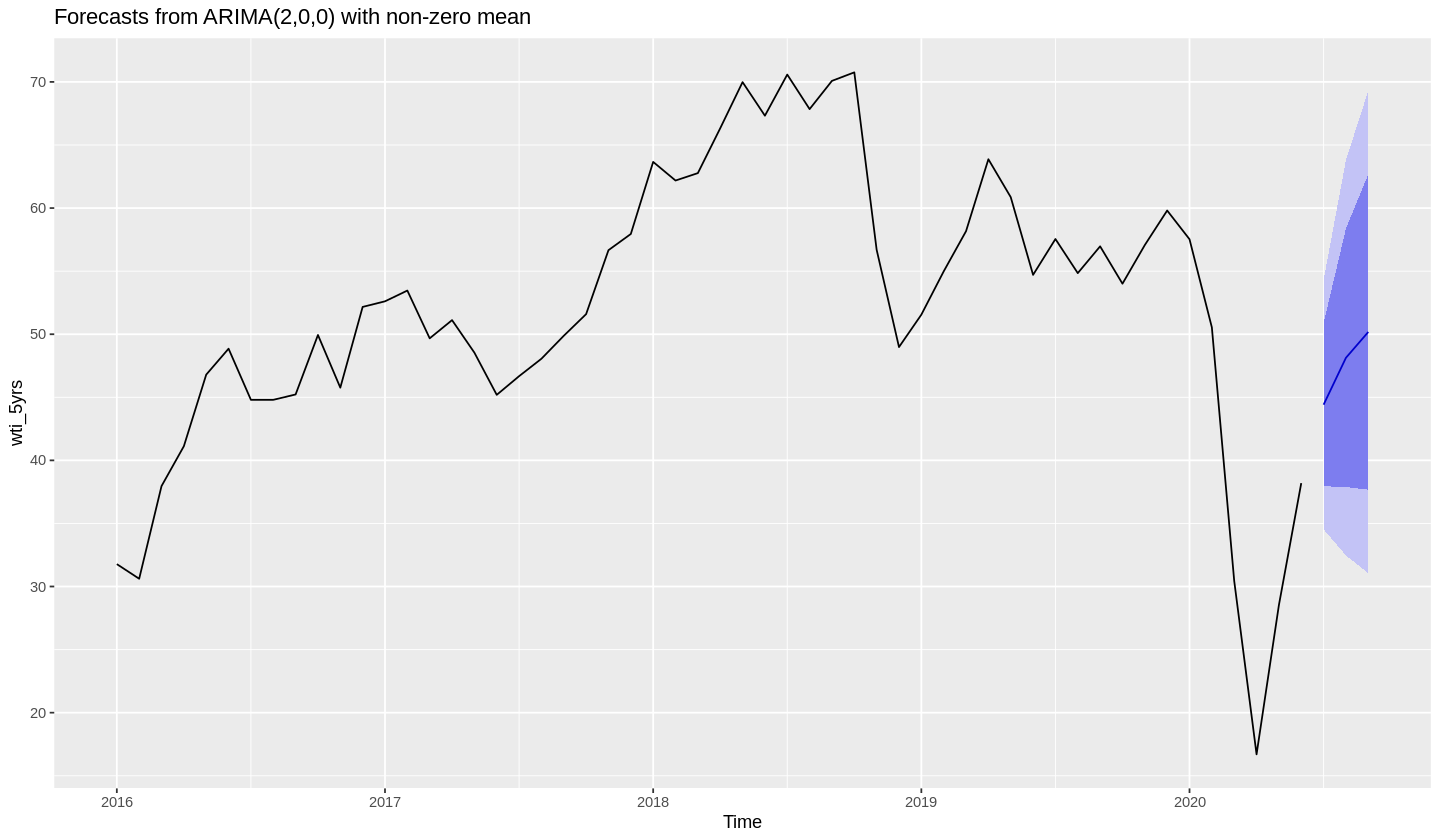

In [71]:
# Forecast 3 periods into the future
forward = forecast(ar02_fit, h = 3)
# Plot the model
autoplot(forward)

The AR(2) model has a lower RMSE, so it seems to be a better model.

## Summary

On this lab we learned how to used analytical methods to analyze time series data and build forecasting models. We analyzed financial data in different forms and learned how to transform common csv files and financial data in R to perform analysis. Some of the topics covered on this lab include forecasting performance measures, moving average, exponential smoothing methods, and the Holt-Winters method.

<a href="https://www.coursera.org/learn/applying-data-analytics-business-in-finance"> <img src="./resources/illinois_banner.png" alt="applying-data-analytics-business-in-finance"/> </a>